In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_gbq
import pydata_google_auth
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.cloud import bigquery
from tqdm.notebook import tqdm
from dateutil import tz
from BigQueryTools import QueryTool
import re

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    # Set auth_local_webserver to True to have a slightly more convienient
    # authorization flow. Note, this doesn't work if you're running from a
    # notebook on a remote sever, such as over SSH or with Google Colab.
    auth_local_webserver=True,
)

bq = QueryTool()

%load_ext google.cloud.bigquery
%env GCLOUD_PROJECT=nbcu-ds-sandbox-a-001

env: GCLOUD_PROJECT=nbcu-ds-sandbox-a-001


# QUALIFY speed test

In [16]:
%%bigquery --project nbcu-ds-sandbox-a-001

SELECT adobe_tracking_id
        , report_date
        , row_number() OVER(partition by adobe_tracking_id order by report_date ) as upgrade_row_number -- rank the number of times a user upgrade
        , current_date() -- disable results caching
FROM       
        (
            SELECT adobe_tracking_id
                    , report_date
                    , paying_account_flag as paying_account_flag_today
                    , LAG(paying_account_flag,1) OVER ( partition by adobe_tracking_id order by report_date  ) as paying_account_flag_yestd -- paying flag yesterday
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
            WHERE report_date between '2022-01-01' and '2022-01-07' -- don't add report_date since we need to distinguish upgrades from beginnning of time 
        )
WHERE paying_account_flag_today = 'Paying' AND paying_account_flag_yestd = 'NonPaying'
order by 3,2,1

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,upgrade_row_number,f0_
0,++9P2+WhbQt4rjQWiakE+OtWVZ5gBDESVZlhsFLO/o8=,2022-01-02,1,2023-03-03
1,++BZuALDJvn4Uxxo6fv37L4JkSqKDdsnfBGUu3rOhGc=,2022-01-02,1,2023-03-03
2,++O4U6CfhQofob0caUsUAiWrmBLg/1V1xn7K859sX6Q=,2022-01-02,1,2023-03-03
3,++aIiiCONAa+hayeE4idJI4qgLMak1RT9M76RdEMu+4=,2022-01-02,1,2023-03-03
4,++bwvsqrgOQEDtjMqCdFtQo0QWbRRZgNzBJRTeDJRYI=,2022-01-02,1,2023-03-03
...,...,...,...,...
232286,GLASehsS05Pc8PMPNCtfU6jgQzaS7AoFFADyzqYHB+M=,2022-01-07,2,2023-03-03
232287,eXcU8h+m46HjlaJVUz/n4u005866yleewMshl8heX4M=,2022-01-07,2,2023-03-03
232288,kT2X7Ykx4m9Pry/Z3QsIz4omu0u06VNUGWRORrs5z9s=,2022-01-07,2,2023-03-03
232289,uRoiS67Kr6o55445yaIQAUlIq8v0iWPG0BtNcR4CvU8=,2022-01-07,2,2023-03-03


In [17]:
%%bigquery --project nbcu-ds-sandbox-a-001

with cte as (
SELECT adobe_tracking_id
        , report_date
        , current_date() -- disable results caching
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
WHERE report_date between '2022-01-01' and '2022-01-07'
QUALIFY (paying_account_flag = 'Paying') and (LAG(paying_account_flag,1) over(partition by adobe_tracking_id order by report_date) = 'NonPaying')
)
SELECT adobe_tracking_id
        , report_date
        , row_number() OVER(partition by adobe_tracking_id order by report_date ) as upgrade_row_number -- rank the number of times a user upgrade
FROM cte
order by 3,2,1

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,upgrade_row_number
0,++9P2+WhbQt4rjQWiakE+OtWVZ5gBDESVZlhsFLO/o8=,2022-01-02,1
1,++BZuALDJvn4Uxxo6fv37L4JkSqKDdsnfBGUu3rOhGc=,2022-01-02,1
2,++O4U6CfhQofob0caUsUAiWrmBLg/1V1xn7K859sX6Q=,2022-01-02,1
3,++aIiiCONAa+hayeE4idJI4qgLMak1RT9M76RdEMu+4=,2022-01-02,1
4,++bwvsqrgOQEDtjMqCdFtQo0QWbRRZgNzBJRTeDJRYI=,2022-01-02,1
...,...,...,...
232286,GLASehsS05Pc8PMPNCtfU6jgQzaS7AoFFADyzqYHB+M=,2022-01-07,2
232287,eXcU8h+m46HjlaJVUz/n4u005866yleewMshl8heX4M=,2022-01-07,2
232288,kT2X7Ykx4m9Pry/Z3QsIz4omu0u06VNUGWRORrs5z9s=,2022-01-07,2
232289,uRoiS67Kr6o55445yaIQAUlIq8v0iWPG0BtNcR4CvU8=,2022-01-07,2


In [15]:
%%bigquery --project nbcu-ds-sandbox-a-001

SELECT adobe_tracking_id
        , report_date
        , row_number() OVER(partition by adobe_tracking_id order by report_date ) as upgrade_row_number -- rank the number of times a user upgrade
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
WHERE report_date between '2022-01-01' and '2022-01-07'
QUALIFY (paying_account_flag = 'Paying') and (LAG(paying_account_flag,1) over(partition by adobe_tracking_id order by report_date) = 'NonPaying')
order by 3,2,1

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,upgrade_row_number
0,++9P2+WhbQt4rjQWiakE+OtWVZ5gBDESVZlhsFLO/o8=,2022-01-02,2
1,++BZuALDJvn4Uxxo6fv37L4JkSqKDdsnfBGUu3rOhGc=,2022-01-02,2
2,++O4U6CfhQofob0caUsUAiWrmBLg/1V1xn7K859sX6Q=,2022-01-02,2
3,++aIiiCONAa+hayeE4idJI4qgLMak1RT9M76RdEMu+4=,2022-01-02,2
4,++bwvsqrgOQEDtjMqCdFtQo0QWbRRZgNzBJRTeDJRYI=,2022-01-02,2
...,...,...,...
232286,zytjwALhwovNtYv1jrNBivgYnpB0P8x4lXqbE0Jbr24=,2022-01-07,7
232287,zz6VfVUYUU048zOqEiQ6okOuDJ07Rv5MVI1hVgWHjqI=,2022-01-07,7
232288,zz7kz8DR4vbk37Z6qzCdA/3gJ+2ld66sEEPPfX0fkSA=,2022-01-07,7
232289,zzQ7pCcZjrj1HYboqlJIGWHjjOJLfufzzA8oeJPXXqU=,2022-01-07,7


# Transactional filter

In [3]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT distinct campaign_name
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
where lower(campaign_name) like 'transactional%'

Query is running:   0%|          |

Downloading:   0%|          |

,campaign_name
0,TransactionalTermsOfUseEngaged20221028
1,Transactional_ProductAnnualRenewal_20220805
2,Transactional_OSDeprecation_20210218
3,TransactionalTermsOfUseNONEngaged20221028
4,TransactionalFamilyControlProfile20221209


In [12]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT * 
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.INFORMATION_SCHEMA.COLUMNS`
where table_name = 'SILVER_MPARTICLE_BRAZE'

Query is running:   0%|          |

Downloading:   0%|          |

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default,rounding_mode
0,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,household_id,1,YES,STRING,NEVER,None,None,NO,None,NO,NO,1,NULL,NULL,None
1,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,adobe_tracking_id,2,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
2,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,campaign_name,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,3,NULL,NULL,None
3,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,campaign_variant_name,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
4,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,campaign_tags,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
5,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,message_variant_channel,6,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
6,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,canvas_name,7,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
7,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,canvas_variant_name,8,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
8,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,canvas_step_name,9,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
9,nbcu-ds-prod-001,PeacockDataMartSilver,SILVER_MPARTICLE_BRAZE,canvas_tags,10,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None


# Email Engager Discrepancy

### Jan

In [38]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT  COUNT(DISTINCT identity)
FROM `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView`
WHERE (eventName = 'Email Opens')
AND (machineOpen IS NULL)
AND date(eventTimestamp) BETWEEN DATE_SUB('2023-01-31', INTERVAL 1 YEAR) AND '2023-01-31'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails


Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,50126984


### Feb

In [39]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT  COUNT(DISTINCT identity)
FROM `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView`
WHERE (eventName = 'Email Opens')
AND (machineOpen IS NULL)
AND date(eventTimestamp) BETWEEN DATE_SUB('2023-02-28', INTERVAL 1 YEAR) AND '2023-02-28'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails


Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,38570038


## All Opens

In [36]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT COUNT(DISTINCT identity)
FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
WHERE eventName = 'Email Opens'
AND date(eventTimestamp) BETWEEN DATE_SUB('2023-01-31', INTERVAL 1 YEAR) AND '2023-01-31'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails


Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,60164590


In [37]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT COUNT(DISTINCT identity) 
FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
WHERE (eventName = 'Email Opens')
AND date(eventTimestamp) BETWEEN DATE_SUB('2023-02-28', INTERVAL 1 YEAR) AND '2023-02-28'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails


Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,59949647


## Hard Dates

In [42]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT COUNT(DISTINCT identity)
FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
WHERE (eventName = 'Email Opens')
AND (machineOpen IS NULL)
AND date(eventTimestamp) BETWEEN '2022-01-31' AND '2023-01-31'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails


Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,50126984


In [43]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT COUNT(DISTINCT identity) 
FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
WHERE (eventName = 'Email Opens')
AND (machineOpen IS NULL)
AND date(eventTimestamp) BETWEEN '2022-02-28' AND '2023-02-28'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails


Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,38570038


### Email Acitivity History

In [45]:
%%bigquery --project nbcu-ds-sandbox-a-001

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Activity_Summary` AS
SELECT  DATE_TRUNC(DATE(eventTimestamp),MONTH)                                                                          AS month
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') THEN identity else null end)                               AS unique_all_email_opens
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') AND (machineOpen is null) THEN identity else null end)     AS unique_organic_email_opens
--       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') AND (machineOpen is null) THEN bid else null end)          AS unique_organic_email_opens_adobe_id
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') AND (machineOpen is not null) THEN identity else null end) AS unique_machine_opens
--       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') AND (machineOpen is not null) THEN bid else null end)      AS unique_machine_opens_adobe_id
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Sends') THEN identity else null end)                               AS unique_sends
--       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Sends') THEN bid else null end)                                    AS unique_sends_adobe_id
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Deliveries') THEN identity else null end)                          AS unique_deliveries
--       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Deliveries') THEN bid else null end)                               AS unique_deliveries_adobe_id
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Bounces') THEN identity else null end)                             AS unique_bounces
--       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Bounces') THEN bid else null end)                                  AS unique_bounces_adobe_id
FROM `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` a
--LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Braze_Id_Adobe_Id_Map` b ON b.bid = a.identity
WHERE lower(campaignName) NOT LIKE 'transactional%' 
AND DATE_TRUNC(DATE(eventTimestamp),MONTH) BETWEEN '2021-08-28' and '2023-02-28'-- Exclude transactional emails
GROUP BY  1

Query is running:   0%|          |

""


In [47]:
%%bigquery df --project nbcu-ds-sandbox-a-001
select * from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Activity_Summary` order by month

Query is running:   0%|          |

Downloading:   0%|          |

In [81]:
import matplotlib.pyplot as plt
import plotly.express as px

temp = df[['month', 'unique_organic_email_opens', 'unique_machine_opens']]
temp = temp.set_index('month')
fig = px.line(temp, labels={"month": "Month", "value": "Email Opens"})

newnames = {
"unique_organic_email_opens": "Organic",
"unique_machine_opens": "Machine"
}
fig.update_layout(legend_title="Category")
fig.for_each_trace(lambda t: t.update(name = newnames[t.name], legendgroup = newnames[t.name]))

In [87]:
%%bigquery df2 --project nbcu-ds-sandbox-a-001

SELECT  DATE(eventTimestamp)                                                                      AS month
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') THEN identity else null end)                               AS unique_all_email_opens
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') AND (machineOpen is null) THEN identity else null end)     AS unique_organic_email_opens
       ,COUNT(DISTINCT CASE WHEN (eventName = 'Email Opens') AND (machineOpen is not null) THEN identity else null end) AS unique_machine_opens
FROM `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` a
WHERE DATE(eventTimestamp) BETWEEN '2022-02-01' and '2022-03-31'
AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails
GROUP BY  1
order by 1

Query is running:   0%|          |

Downloading:   0%|          |

In [88]:
import matplotlib.pyplot as plt
import plotly.express as px

temp = df2[['month', 'unique_organic_email_opens', 'unique_all_email_opens', 'unique_machine_opens']]
temp = temp.set_index('month')
px.line(temp)

Most opens are machine opens

Open category distinguishing feature began at EoM Feb 22

# Pipeline Duplication Detection

## Holdout Seperation

In [82]:
params = {
    'report_start_date': '2023-01-01',
    'report_end_date': '2023-01-31'
}

In [85]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH 
Holdout AS (
    select distinct holdout.adobe_tracking_id
    from (
    select distinct TrackingId as adobe_tracking_id -- distinct Hold_Out_Type_Current --cohort, count(distinct TrackingId)
    from `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP` 
    where cohort = 'January2023' 
    and Hold_Out_Type_Current = 'Owned Email Holdout'
    -- Exclude those who are assigned to Email Holdout but actually received emails
    ) holdout
    left join 
    (SELECT DISTINCT adobe_tracking_id
        FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE` 
        WHERE event_name = 'Email Deliveries' 
        AND event_date >= @report_start_date
        AND event_date <= @report_end_date 
    ) delivered-- Email Delivered ever 
    on holdout.adobe_tracking_id = delivered.adobe_tracking_id
    and delivered.adobe_tracking_id is null 
)
select count(*) from Holdout

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,3381634


In [86]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH
Holdout AS (
    select distinct holdout.adobe_tracking_id
    from (
    select distinct TrackingId as adobe_tracking_id -- distinct Hold_Out_Type_Current --cohort, count(distinct TrackingId)
    from `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP` 
    where cohort = 'January2023' 
    and Hold_Out_Type_Current = 'Owned Email Holdout'
    -- Exclude those who are assigned to Email Holdout but actually received emails
    ) holdout
    left join 
    (SELECT DISTINCT adobe_tracking_id
        FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE` 
        WHERE event_name = 'Email Deliveries' 
        AND event_date >= @report_start_date
        AND event_date <= @report_end_date 
    ) delivered-- Email Delivered ever 
    on holdout.adobe_tracking_id = delivered.adobe_tracking_id
    where delivered.adobe_tracking_id is null 
)
select count(*) from Holdout

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,3339832


## Joining Duplication Detection

In [90]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Save_Denom` AS 
    SELECT distinct adobe_tracking_id, date_of_last_view -- no need for max (days_since_last_view), can be saved multiple times, dedup later
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES` 
    WHERE report_date BETWEEN @report_start_date AND @report_end_date 
    AND days_since_last_view BETWEEN 15 AND 29 -- this guarantees we are only getting people who have at least past the 'lapsing' phase in the time period.

Query is running:   0%|          |

""


In [152]:
%%bigquery --project nbcu-ds-sandbox-a-001
select count(adobe_tracking_id), count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Save_Denom`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,23859900,22192155


In [93]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Save_Num` AS 
    SELECT distinct a.adobe_tracking_id      
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Save_Denom` a
    INNER JOIN `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_VIDEO` VIDEO 
        ON a.adobe_tracking_id = VIDEO.adobe_tracking_id 
        AND adobe_date BETWEEN @report_start_date AND @report_end_date
        AND VIDEO.adobe_date BETWEEN DATE_ADD(date_of_last_view, INTERVAL 15 day) AND DATE_ADD(date_of_last_view, INTERVAL 29 day)

Query is running:   0%|          |

""


In [153]:
%%bigquery --project nbcu-ds-sandbox-a-001
select count(adobe_tracking_id), count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Save_Num`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,6731988,6731988


In [94]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Winback_Denom` AS 
    SELECT distinct adobe_tracking_id, date_of_last_view
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES` 
    WHERE report_date BETWEEN @report_start_date AND @report_end_date 
    AND days_since_last_view BETWEEN 30 AND 90-- this guarantees we are only getting people who have at least past the 'lapsing' phase in the time period.

Query is running:   0%|          |

""


In [154]:
%%bigquery --project nbcu-ds-sandbox-a-001
select count(adobe_tracking_id), count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Winback_Denom`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,23751639,23751639


In [95]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Winback_Num` AS 
    SELECT distinct a.adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Winback_Denom` a
    INNER JOIN `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_VIDEO`  VIDEO 
        ON a.adobe_tracking_id = VIDEO.adobe_tracking_id 
        AND VIDEO.adobe_date BETWEEN @report_start_date AND @report_end_date 
        AND VIDEO.adobe_date BETWEEN DATE_ADD(date_of_last_view, INTERVAL 30 day) 
            AND DATE_ADD(date_of_last_view, INTERVAL 90 DAY)

Query is running:   0%|          |

""


In [155]:
%%bigquery --project nbcu-ds-sandbox-a-001
select count(adobe_tracking_id), count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Winback_Num`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,5663721,5663721


In [96]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Upgrade_Denom` AS 
    SELECT distinct adobe_tracking_id 
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`  USER
    WHERE paying_account_flag = 'NonPaying' 
    AND USER.report_date BETWEEN @report_start_date and @report_end_date

Query is running:   0%|          |

""


In [156]:
%%bigquery --project nbcu-ds-sandbox-a-001
select count(adobe_tracking_id), count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Upgrade_Denom`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,91746405,91746405


In [97]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Upgrade_Num` AS 
    SELECT  distinct adobe_tracking_id
    FROM
        (SELECT  
                report_date
             , adobe_tracking_id     
         FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`  USER
         WHERE entitlement_change_flag IN ('Upgrade: Free to Premium'
                                         , 'Upgrade: Free to Premium+'
                                         , 'Upgrade: Premium to Premium+') 
         AND paying_account_flag = 'Paying'                                            
            AND USER.report_date BETWEEN @report_start_date and @report_end_date
        ) 

Query is running:   0%|          |

""


In [157]:
%%bigquery --project nbcu-ds-sandbox-a-001
select count(adobe_tracking_id), count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Upgrade_Num`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,1514290,1514290


In [98]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Cancel_Save_Denom` AS
    SELECT distinct adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
    WHERE paying_account_flag = 'Paying'
    AND auto_renew_flag = 'OFF'
    AND report_date BETWEEN @report_start_date and @report_end_date

Query is running:   0%|          |

""


In [99]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Cancel_Save_Num` AS 
    SELECT  distinct adobe_tracking_id
    FROM
    (
        SELECT  adobe_tracking_id
            ,report_date
            ,auto_renew_flag                                                                      AS auto_renew_flag_today
            ,LEAD(auto_renew_flag,1) OVER ( partition by adobe_tracking_id ORDER BY report_date ) AS auto_renew_flag_next_day
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE report_date BETWEEN @report_start_date AND @report_end_date
        ORDER BY 1, 2 
    )
    WHERE auto_renew_flag_today = 'OFF'
    AND auto_renew_flag_next_day = 'ON'

Query is running:   0%|          |

""


In [102]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.New_Upgrade_Denom` AS 
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_never`
    WHERE report_date BETWEEN @report_start_date AND @report_end_date

Query is running:   0%|          |

""


In [103]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.New_Upgrade_Num` AS 
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
    WHERE upgrade_row_number = 1
    AND report_date BETWEEN @report_start_date AND @report_end_date

Query is running:   0%|          |

""


In [104]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Paid_Winbacks_Denom` AS 
    SELECT  distinct adobe_tracking_id
    FROM
    (
        SELECT  adobe_tracking_id
            ,report_date
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE paying_account_flag = 'NonPaying'
        AND report_date BETWEEN @report_start_date AND @report_end_date 
    )
    WHERE adobe_tracking_id NOT IN ( SELECT distinct adobe_tracking_id FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_never` WHERE report_date BETWEEN @report_start_date AND @report_end_date)

Query is running:   0%|          |

""


In [105]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Paid_Winbacks_Num` AS 
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
    WHERE upgrade_row_number > 1
    AND report_date BETWEEN @report_start_date AND @report_end_date

Query is running:   0%|          |

""


In [106]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.EOM_Paid_Churn_Denom` AS 
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
    WHERE date = @report_end_date
    AND entitlement = 'Paid'

Query is running:   0%|          |

""


In [107]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.EOM_Paid_Churn_Num` AS 
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
    WHERE date = @report_end_date
    AND entitlement = 'Paid'
    AND Churn_flag = 'Churn'

Query is running:   0%|          |

""


# Silver Churn QA

In [19]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT  *
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
WHERE base_date = '2023-01-31'
and entitlement = 'Paid'
limit 10;

Query is running:   0%|          |

Downloading:   0%|          |

,Date,base_date,original_entitlement,original_entitlement_updated,original_account_tenure,original_acquisition_channel,original_trial_flag,original_tenure_paid_lens,primary_device_name,entitlement,billing_platform,bundling_partner,account_tenure_base_date,Churn_type,tenure_paid_lens,billing_cycle,Churn_flag,adobe_tracking_id,entitlement_updated
0,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Non-viewer,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,py712oIUc87nRHznGaL1+ZrnCLR+YDVbxWhkEuSqPiY=,Premium Paid Bundled
1,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Ios Mobile,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,pAUKNbskvQ6HTZd1bMt8EdQRoAr/MAUE1ntGhr9Z8vg=,Premium Paid Bundled
2,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Www,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,NOh5dJ1BC8kGOc773qJTKqgH3Iz3sCZxt1l9llPg4Hw=,Premium Paid Bundled
3,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Www,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,oGkWxDOJaLTTUHLd6nV9mQqFmqmQQUIheSqF1dbJc9c=,Premium Paid Bundled
4,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Samsung Tv,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,IL3J5qcHWF/R7+jwUpcMT38/Q4HkLY6TnNs7gE/zN10=,Premium Paid Bundled
5,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Roku,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,t7mfMe1KBMe4Qakrai9A2oF2m7xJDi8ZyX8JuOYNjDM=,Premium Paid Bundled
6,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Ios Mobile,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,QkbaIaMK3jPb6ITabK2/F0hMGYc9g13/vD2aD0q3Hm0=,Premium Paid Bundled
7,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Www,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,PquU+X6S2YLK1qAGOS+qUwXS17AWYHhe+jb2mm17ewY=,Premium Paid Bundled
8,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Samsung Tv,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,JHif6qSvwShn5NHHoKa+nghFF11Hg61yCe7tRkgVRn0=,Premium Paid Bundled
9,2023-02-28,2023-01-31,Premium,Premium Paid Bundled,0 - 1 Day,NBCU,False,0-90 days,Ios Mobile,Paid,NBCU,Voucher - PokerFacePublic,<90 Days,N/A,0-90 days,ANNUAL,Not Churned,rWddN2Rbm3DLcHKC2To4zm/yfW4sAKVvOwJqv2IO9tY=,Premium Paid Bundled


In [17]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT  churn_flag
       ,COUNT(DISTINCT adobe_tracking_id)
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
WHERE base_date = '2023-01-31'
and entitlement = 'Paid'
GROUP BY  1

Query is running:   0%|          |

Downloading:   0%|          |

,churn_flag,f0_
0,Not Churned,19993668
1,Churn,1312746


In [13]:
%%bigquery --project nbcu-ds-sandbox-a-001

SELECT  CASE WHEN paying_account_flag = 'Paying' THEN 'Not Churned'  ELSE 'Churned' END AS churn_flag
       ,COUNT(DISTINCT paying_base.adobe_tracking_id)
FROM
(
	SELECT  adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE report_date = '2023-01-31'
	AND paying_account_flag = 'Paying' 
) paying_base
LEFT JOIN
(
	SELECT  adobe_tracking_id
	       ,paying_account_flag
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE report_date = DATE_ADD('2023-01-31', INTERVAL 30 DAY) 
) churn_status
ON paying_base.adobe_tracking_id = churn_status.adobe_tracking_id
GROUP BY 1

Query is running:   0%|          |

Downloading:   0%|          |

,churn_flag,f0_
0,Not Churned,19932447
1,Churned,1373967


# Churn Window

In [26]:
%%bigquery --project nbcu-ds-sandbox-a-001
SELECT  *
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
WHERE base_date = '2023-02-28'
and entitlement = 'Paid'
limit 10;

Query is running:   0%|          |

Downloading: |          |

,Date,base_date,original_entitlement,original_entitlement_updated,original_account_tenure,original_acquisition_channel,original_trial_flag,original_tenure_paid_lens,primary_device_name,entitlement,billing_platform,bundling_partner,account_tenure_base_date,Churn_type,tenure_paid_lens,billing_cycle,Churn_flag,adobe_tracking_id,entitlement_updated


# Lookback Window

In [23]:
%%bigquery --project nbcu-ds-sandbox-a-001 

select DATE_SUB(DATETIME_TRUNC('2023-02-01', QUARTER), INTERVAL 4 MONTH), 

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,2022-09-01


# CustomerPermissionView join

In [ ]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.All_Cohorts_v4_Jan23` AS (
    -- email targetable and holdout cohort, users signed up after 2020/8/11
     SELECT distinct a.adobe_tracking_id as aid
     , cohort
     , user.account_type

    FROM         -- Include email engagers only: users with at least one email open in the last year that is not a transactional email
     (
        SELECT DISTINCT identity 
        FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
        WHERE eventName = 'Email Opens' 
        AND machineOpen IS NULL
        AND date(eventTimestamp) BETWEEN DATE_SUB(@report_end_date, INTERVAL 1 YEAR) AND @report_end_date
        AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails
    ) Email_Engagers --opened email at least once, using other open 
    
    INNER JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Braze_Id_Adobe_Id_Map` mapping
    ON mapping.bid = Email_Engagers.identity

    INNER JOIN
        (
            SELECT *, 'Email_Targeted' as cohort from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Targeted_v4_Jan23`
            UNION ALL
            SELECT *, 'Holdout' as cohort from `nbcu-ds-sandbox-a-001.SLi_sandbox.Holdout_v4_Jan23`
        ) a
    ON a.adobe_tracking_id = mapping.aid
        
    --add attribute: account_type 
    INNER JOIN ( SELECT * FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` WHERE report_date = @report_end_date ) user
    ON a.adobe_tracking_id = user.adobe_tracking_id 

    -- for after 2021/july, email channel only, take out all abandon MAAs
    INNER JOIN 
    (SELECT DISTINCT adobe_tracking_id FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES` 
        WHERE report_date = @report_end_date
        AND date_of_last_view IS NOT NULL 
    ) abandon_maa 
    ON a.adobe_tracking_id = abandon_maa.adobe_tracking_id

    -- exclude unsubscribed
    LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_v4_Jan23` unsub
    ON a.adobe_tracking_id = unsub.adobe_tracking_id
    WHERE unsub.adobe_tracking_id IS NULL
)

# Holdout comparison

In [ ]:
SELECT  TrackingId aid
FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP`
WHERE cohort = 'October2022'
AND Hold_Out_Type_Current = 'Owned Email Holdout'
AND (
    TrackingId IN (
        -- Find subs that registered in the last 4 months in the last 4 months 
        SELECT  adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE report_date = '2022-10-01'
        AND date(registration_date) BETWEEN date_add('2022-10-01', interval -4 month) AND '2022-10-01' 
    ) 
    
    OR 
    
    TrackingId IN (
        -- Find subs that have received an email IN the last 4 months 
        SELECT  adobe_tracking_id
        FROM
        (
            SELECT  adobe_tracking_id
                ,last_value(event_name) over(partition by adobe_tracking_id ORDER BY eventTimestamp) category -- identify if the last action a sub took was to unsubscribe
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
            WHERE date(eventTimestamp) BETWEEN date_add('2022-10-01', interval -4 month) AND '2022-10-01'
            AND event_name in('Email Deliveries', 'Email Unsubscribes') --isolate users who have either received an email or unsubscribed
            AND lower(campaign_name) not like '%transactional%' -- remove transactional emails 
        )
        WHERE category = 'Email Deliveries' -- remove unsubscribers 
    )
)

In [55]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  RegistrationDate, TIMESTAMP(RegistrationDate), DATETIME(TIMESTAMP(RegistrationDate), 'America/New_York'),  DATE(TIMESTAMP(RegistrationDate), 'America/New_York')
FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP`
WHERE cohort = format_timestamp('%B%Y', DATETIME_TRUNC(@report_start_date, QUARTER)) -- get cohort name as month of quarter start + year
AND Hold_Out_Type_Current = 'Owned Email Holdout'
limit 10;

Query is running:   0%|          |

Downloading:   0%|          |

,RegistrationDate,f0_,f1_
0,2022-09-01 06:41:15.206,2022-09-01 06:41:15.206000+00:00,2022-09-01 02:41:15.206
1,2022-09-01 06:02:17.059,2022-09-01 06:02:17.059000+00:00,2022-09-01 02:02:17.059
2,2022-09-01 06:25:04.393,2022-09-01 06:25:04.393000+00:00,2022-09-01 02:25:04.393
3,2022-09-01 06:04:45.482,2022-09-01 06:04:45.482000+00:00,2022-09-01 02:04:45.482
4,2022-09-01 06:20:54.650,2022-09-01 06:20:54.650000+00:00,2022-09-01 02:20:54.650
5,2022-09-01 06:55:37.346,2022-09-01 06:55:37.346000+00:00,2022-09-01 02:55:37.346
6,2022-09-01 06:26:24.414,2022-09-01 06:26:24.414000+00:00,2022-09-01 02:26:24.414
7,2022-09-01 06:41:14.772,2022-09-01 06:41:14.772000+00:00,2022-09-01 02:41:14.772
8,2022-09-01 06:37:10.786,2022-09-01 06:37:10.786000+00:00,2022-09-01 02:37:10.786
9,2022-09-01 06:08:28.945,2022-09-01 06:08:28.945000+00:00,2022-09-01 02:08:28.945


## Build testing table

In [177]:
params = {
    'report_start_date': '2022-10-01',
    'report_end_date': '2022-10-01'
}

In [178]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Holdout_Test` AS

WITH 
email_holdout as (
    SELECT  distinct holdout.adobe_tracking_id
    FROM
    (
        SELECT  distinct TrackingId AS adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP`
        WHERE cohort = format_timestamp('%B%Y', DATETIME_TRUNC(@report_start_date, QUARTER)) -- get cohort name as month of quarter start + year
        AND Hold_Out_Type_Current = 'Owned Email Holdout'
        AND DATE(TIMESTAMP(RegistrationDate), 'America/New_York') <= @report_end_date
    ) holdout
    -- Exclude those who are assigned to Email Holdout but actually received emails in holdout period (cooloff period manually implemented and unreliable)
    LEFT JOIN (
        SELECT DISTINCT adobe_tracking_id 
        FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
        WHERE event_name = 'Email Deliveries' 
        AND event_date BETWEEN DATETIME_TRUNC(@report_start_date, QUARTER) and @report_end_date
        AND LOWER(campaign_name) NOT LIKE 'transactional%' -- Exclude transactional emails
    ) received
    ON holdout.adobe_tracking_id = received.adobe_tracking_id
    WHERE received.adobe_tracking_id IS NULL
)
, email_channel_qualifier as (
    -- Engagement: Deliveries 4 months before start of the holdout period, defined as start of quarter
    SELECT DISTINCT adobe_tracking_id AS aid 
    FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
    WHERE event_name = 'Email Deliveries'
    AND event_date BETWEEN DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 4 MONTH) AND @report_end_date
    AND lower(campaign_name) NOT LIKE 'transactional%' -- Exclude transactional emails

    UNION ALL

    -- New users joining after 4 months before start of the cohort period
    SELECT DISTINCT adobe_tracking_id AS aid
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    WHERE registration_date between DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 4 MONTH) AND @report_end_date
)
, email_unsubs as (
    SELECT DISTINCT adobe_tracking_id
    FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE` 
    WHERE event_name = 'Email Unsubscribes' 
    AND event_date <= @report_end_date
)

SELECT  distinct email_holdout.adobe_tracking_id AS aid
FROM email_holdout

-- Include only those who received email in the current reporting period or are in holdout
INNER JOIN email_channel_qualifier
ON email_holdout.adobe_tracking_id = email_channel_qualifier.aid

-- for after 2021/july, email channel only, take out all abandon MAAs
INNER JOIN
    (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES`
        WHERE report_date = @report_end_date
        AND date_of_last_view IS NOT NULL
    ) abandon_maa
ON email_holdout.adobe_tracking_id = abandon_maa.adobe_tracking_id

-- exclude unsubscribed
LEFT JOIN email_unsubs
ON email_holdout.adobe_tracking_id = email_unsubs.adobe_tracking_id
WHERE email_unsubs.adobe_tracking_id IS NULL

Query is running:   0%|          |

""


In [180]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
select count(distinct aid) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Holdout_Test`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,1962559


In [181]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
    SELECT count(distinct aid)
    from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Holdout_Test` a --`nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Holdout_Test` a
    --add attribute: account_type at the end of the reporting period
    INNER JOIN
        (
            SELECT  DISTINCT adobe_tracking_id
                ,paying_account_flag
                ,billing_cycle
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
            WHERE report_date = '2022-10-31' 
            and paying_account_flag = 'Paying'
            and billing_cycle = 'MONTHLY'
        ) user
    ON a.aid = user.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,391059


In [182]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH 
base as (
    SELECT aid
    from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Holdout_Test` a --`nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Holdout_Test` a
    --add attribute: account_type at the end of the reporting period
    INNER JOIN
        (
            SELECT  DISTINCT adobe_tracking_id
                ,paying_account_flag
                ,billing_cycle
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
            WHERE report_date = '2022-10-31' 
        ) user
    ON a.aid = user.adobe_tracking_id
    WHERE paying_account_flag = 'Paying'
    and billing_cycle = 'MONTHLY'
)
, EOM_Paid_Churn_Denom AS (
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
    WHERE base_date = '2022-10-31' -- churn date would be on 11-30
    AND entitlement = 'Paid'
)
, EOM_Paid_Churn_Num AS (
    SELECT  distinct adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
    WHERE base_date = '2022-10-31'
    AND entitlement = 'Paid'
    AND Churn_flag = 'Churn'
)
, cte1 as (
    SELECT aid
        ,EOM_Paid_Churn_Denom.adobe_tracking_id  AS Churn_Denom
        ,EOM_Paid_Churn_Num.adobe_tracking_id    AS Churn_Num
    FROM base a
    LEFT JOIN EOM_Paid_Churn_Denom
        on a.aid = EOM_Paid_Churn_Denom.adobe_tracking_id
    LEFT JOIN EOM_Paid_Churn_Num
        on EOM_Paid_Churn_Denom.adobe_tracking_id = EOM_Paid_Churn_Num.adobe_tracking_id
)
, cte2 as (
    SELECT COUNT(distinct Churn_Denom )   AS EOM_Paid_Churn_Denom_Targeted
        ,COUNT(distinct Churn_Num )     AS EOM_Paid_Churn_Num_Targeted
    FROM cte1
)
select EOM_Paid_Churn_Num_Targeted, EOM_Paid_Churn_Denom_Targeted, safe_divide(EOM_Paid_Churn_Num_Targeted, EOM_Paid_Churn_Denom_Targeted) as churn_rate
from cte2

Query is running:   0%|          |

Downloading:   0%|          |

,EOM_Paid_Churn_Num_Targeted,EOM_Paid_Churn_Denom_Targeted,churn_rate
0,22932,391059,0.058641


# Holdout Delivery 1 month prior vs. start of month

In [ ]:
params = {
    'report_start_date': '2023-01-01',
    'report_end_date': '2023-01-31'
}

In [ ]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

with 
holdout as (
    SELECT  DISTINCT holdout.adobe_tracking_id
    FROM
    (
        SELECT  DISTINCT TrackingId AS adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP`
        WHERE cohort = format_timestamp('%B%Y', DATETIME_TRUNC(@report_start_date, QUARTER)) -- get cohort name as month of quarter start + year
        AND Hold_Out_Type_Current = 'Owned Email Holdout'
        AND DATE(TIMESTAMP(RegistrationDate), 'America/New_York') <= @report_end_date
    ) holdout
    -- Exclude those who are assigned to Email Holdout but actually received emails 1 month prior to holdout start (to include cooloff period)
    LEFT JOIN (
        SELECT DISTINCT adobe_tracking_id 
        FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
        WHERE event_name = 'Email Deliveries' 
        AND event_date BETWEEN @report_start_date and @report_end_date -- DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 1 MONTH) and @report_end_date
        AND LOWER(campaign_name) NOT LIKE 'transactional%' -- Exclude transactional emails
    ) received
    ON holdout.adobe_tracking_id = received.adobe_tracking_id
    WHERE received.adobe_tracking_id IS NULL
)
, qualified as (
    SELECT aid
    FROM (
        -- Engagement: Deliveries 4 months before start of the holdout period, defined as start of quarter
        -- Silver MParticle instead
        SELECT aid
        FROM
            (
                SELECT DISTINCT identity 
                FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
                WHERE eventName = 'Email Deliveries'
                AND date(eventTimestamp) BETWEEN DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 4 MONTH) AND @report_start_date
                AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails
            ) engager_base
        INNER JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Braze_Id_Adobe_Id_Map` mapping
        ON mapping.bid = engager_base.identity
    )

    UNION ALL

    SELECT distinct adobe_tracking_id as aid
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    -- New users joining after 4 months before start of the cohort period
    WHERE registration_date >= DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 4 MONTH)
)
select count(distinct case when cohort = 'Holdout' then  delivered_and_holdout.adobe_tracking_id else null end)
FROM (
    SELECT *, 'Holdout' as cohort from holdout
) delivered_and_holdout

-- Include only those who received email in the current reporting period or are in holdout
INNER JOIN qualified
ON delivered_and_holdout.adobe_tracking_id = qualified.aid

-- for after 2021/july, email channel only, take out all abandon MAAs
INNER JOIN
    (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES`
        WHERE report_date = @report_end_date
        AND date_of_last_view IS NOT NULL
    ) abandon_maa
ON delivered_and_holdout.adobe_tracking_id = abandon_maa.adobe_tracking_id

-- exclude unsubscribed
LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_v4_Jan23` email_unsubs
ON delivered_and_holdout.adobe_tracking_id = email_unsubs.adobe_tracking_id
WHERE email_unsubs.adobe_tracking_id IS NULL

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,1790028


In [ ]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

with 
holdout as (
    SELECT  DISTINCT holdout.adobe_tracking_id
    FROM
    (
        SELECT  DISTINCT TrackingId AS adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP`
        WHERE cohort = format_timestamp('%B%Y', DATETIME_TRUNC(@report_start_date, QUARTER)) -- get cohort name as month of quarter start + year
        AND Hold_Out_Type_Current = 'Owned Email Holdout'
        AND DATE(TIMESTAMP(RegistrationDate), 'America/New_York') <= @report_end_date
    ) holdout
    -- Exclude those who are assigned to Email Holdout but actually received emails 1 month prior to holdout start (to include cooloff period)
    LEFT JOIN (
        SELECT DISTINCT adobe_tracking_id 
        FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
        WHERE event_name = 'Email Deliveries' 
        AND event_date BETWEEN @report_start_date and @report_end_date -- DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 1 MONTH) and @report_end_date
        AND LOWER(campaign_name) NOT LIKE 'transactional%' -- Exclude transactional emails
    ) received
    ON holdout.adobe_tracking_id = received.adobe_tracking_id
    WHERE received.adobe_tracking_id IS NULL
)
, qualified as (
    SELECT aid
    FROM (
        -- Engagement: Deliveries 4 months before start of the holdout period, defined as start of quarter
        -- Silver MParticle instead
        SELECT aid
        FROM
            (
                SELECT DISTINCT identity 
                FROM  `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView` 
                WHERE eventName = 'Email Deliveries'
                AND date(eventTimestamp) BETWEEN DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 4 MONTH) AND @report_start_date
                AND lower(campaignName) NOT LIKE 'transactional%' -- Exclude transactional emails
            ) engager_base
        INNER JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Braze_Id_Adobe_Id_Map` mapping
        ON mapping.bid = engager_base.identity
    )

    UNION ALL

    SELECT distinct adobe_tracking_id as aid
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    -- New users joining after 4 months before start of the cohort period
    WHERE registration_date >= DATE_SUB(DATETIME_TRUNC(@report_start_date, QUARTER), INTERVAL 4 MONTH)
)
select count(distinct case when cohort = 'Holdout' then  delivered_and_holdout.adobe_tracking_id else null end)
FROM (
    SELECT *, 'Holdout' as cohort from holdout
) delivered_and_holdout

-- Include only those who received email in the current reporting period or are in holdout
INNER JOIN qualified
ON delivered_and_holdout.adobe_tracking_id = qualified.aid

-- for after 2021/july, email channel only, take out all abandon MAAs
INNER JOIN
    (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES`
        WHERE report_date = @report_end_date
        AND date_of_last_view IS NOT NULL
    ) abandon_maa
ON delivered_and_holdout.adobe_tracking_id = abandon_maa.adobe_tracking_id

-- exclude unsubscribed
LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_v4_Jan23` email_unsubs
ON delivered_and_holdout.adobe_tracking_id = email_unsubs.adobe_tracking_id
WHERE email_unsubs.adobe_tracking_id IS NULL

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,584141


# Random

In [104]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
select cohort, count(distinct aid) from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Audience_v4_Jan23` group by 1

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,f0_
0,Email_Targeted,34010128
1,Holdout,1789363


# Unsub table with dates

In [6]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs` AS

SELECT adobe_tracking_id, MIN(event_date) as first_unsub_date
FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE` 
WHERE event_name = 'Email Unsubscribes' 
group by 1

Query is running:   0%|          |

""


In [7]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  COUNT(distinct adobe_tracking_id)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs`
WHERE first_unsub_date <= @report_end_date

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,11168573


In [9]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT count(distinct adobe_tracking_id) as unsub_count
FROM  `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_v4_Jan23`

Query is running:   0%|          |

Downloading:   0%|          |

,unsub_count
0,11168573


# Better Unsub table

In [4]:
params = {
    'report_start_date': '2023-01-01',
    'report_end_date': '2023-01-31'
}

In [5]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
with cte as (
    SELECT adobe_tracking_id, count(*) as events
    FROM  `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE` 
    WHERE event_name = 'Email Unsubscribes' 
    AND event_date <= @report_end_date
    group by 1
)
select case when events = 0 then '0' when events = 1 then '1' when events = 2 then '2' else '3+' end, count(adobe_tracking_id) from cte group by 1 order by 1

Query is running:   0%|          |

Downloading:   0%|          |

,f0_,f1_
0,1,9273624
1,2,1656075
2,3+,238874


In [19]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.unsub_test` AS 

with cte as (
    SELECT distinct adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs`
    WHERE first_unsub_date <= @report_end_date
)
select adobe_tracking_id, event_name, event_date, last_value(event_name) over(partition by adobe_tracking_id order by eventTimestamp ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as last_event_name, last_value(event_date) over(partition by adobe_tracking_id order by eventTimestamp ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as last_event_date
from `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
where adobe_tracking_id in (select adobe_tracking_id from cte)
and event_date <= @report_end_date

Query is running:   0%|          |

""


In [22]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params

select last_event_name, count(distinct adobe_tracking_id) from `nbcu-ds-sandbox-a-001.SLi_sandbox.unsub_test`
group by 1
order by 2 desc 

Query is running:   0%|          |

Downloading:   0%|          |

,last_event_name,f0_
0,Campaign Control Group Enrollments,407
1,Push Notification Opens,1194
2,Push Notification Bounces,4753
3,Email Marks As Spam,4941
4,Email Clicks,20515
5,Email Bounces,30657
6,Campaign Conversions,37787
7,Email Sends,41095
8,Canvas Entries - Control,70533
9,Email Unsubscribes,88211


In [48]:
%%bigquery df --project nbcu-ds-sandbox-a-001 --params $params
select last_unsub_date, count(adobe_tracking_id) as unsubs
from (
    SELECT  adobe_tracking_id
        ,MAX(event_date) AS last_unsub_date
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
    WHERE event_name = 'Email Unsubscribes'
    AND event_date <= @report_end_date
    GROUP BY  1
)
group by 1

Query is running:   0%|          |

Downloading:   0%|          |

<AxesSubplot:>

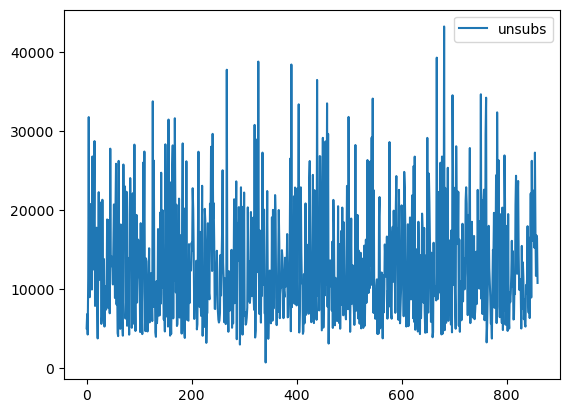

In [49]:
df.plot()

In [53]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
with unsubs as (
    SELECT  adobe_tracking_id
       ,MAX(eventtimestamp) AS last_unsub_timestamp
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
    WHERE event_name = 'Email Unsubscribes'
    and eventtimestamp <= @report_end_date
    GROUP BY  1
)
,deliveries as (
    SELECT  distinct a.adobe_tracking_id
    FROM (
        select adobe_tracking_id, eventtimestamp
        from `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
        WHERE event_name = 'Email Deliveries'
    ) a
    JOIN unsubs b
    ON a.adobe_tracking_id = b.adobe_tracking_id
    AND a.eventtimestamp > b.last_unsub_timestamp

)
SELECT  COUNT(distinct a.adobe_tracking_id) as total_unsubs
       ,COUNT(distinct b.adobe_tracking_id) as users_with_deliveries_after_unsubs
       ,COUNT(distinct a.adobe_tracking_id) - COUNT(distinct b.adobe_tracking_id) as delta
FROM unsubs a
LEFT JOIN deliveries b
ON a.adobe_tracking_id = b.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,total_unsubs,users_with_deliveries_after_unsubs,delta
0,11158437,9815118,1343319


Of those who unsubscribed, what is their receive rate after that day?

# Tally Table - Recursively obtain months in a quarter

In [130]:
params = {
    'report_start_date': '2023-01-31',
    'report_end_date': '2023-03-31'
}

In [131]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH RECURSIVE month_cte AS
(
	SELECT  LAST_DAY(@report_start_date,MONTH) AS eom_dates
	UNION ALL
	SELECT  DATE_ADD(eom_dates,INTERVAL 1 MONTH) AS eom_dates
	FROM month_cte
	WHERE eom_dates <= DATE_TRUNC(@report_end_date, MONTH) 
) , month_ends AS
(
	SELECT  DATE_TRUNC(eom_dates,MONTH) AS Month_Start
	       ,LAST_DAY(eom_dates,MONTH)   AS Month_End
	FROM month_cte
	ORDER BY Month_Start, Month_End
)
SELECT  Month_Start
       ,Month_End
FROM month_ends

Query is running:   0%|          |

Downloading:   0%|          |

,Month_Start,Month_End
0,2023-01-01,2023-01-31
1,2023-02-01,2023-02-28
2,2023-03-01,2023-03-31


## Cross Join Implementation

In [141]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  month_start
       ,COUNT(adobe_tracking_id)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs`
CROSS JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Channel_Dates_Q1_2023`
WHERE first_unsub_date <= month_end
GROUP BY  1
order by 1

Query is running:   0%|          |

Downloading:   0%|          |

,month_start,f0_
0,2023-01-01,11168573
1,2023-02-01,11522737
2,2023-03-01,11792806


In [138]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  COUNT(adobe_tracking_id)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_v4_Jan2023`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,11168573


In [139]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  COUNT(adobe_tracking_id)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_v4_Feb2023`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,11522737


### Another Test

In [205]:
params = {
    'report_start_date': '2023-01-01',
    'report_end_date': '2023-03-31'
}

In [212]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH RECURSIVE month_cte AS
(
	SELECT  LAST_DAY(@report_start_date,MONTH) AS eom_dates
	UNION ALL
	SELECT  DATE_ADD(eom_dates,INTERVAL 1 MONTH) AS eom_dates
	FROM month_cte
	WHERE eom_dates <= DATE_TRUNC(@report_end_date, MONTH) 
) , month_ends AS
(
	SELECT  DATE_TRUNC(eom_dates,MONTH) AS Month_Start
	       ,LAST_DAY(eom_dates,MONTH)   AS Month_End
	FROM month_cte
	ORDER BY Month_Start, Month_End
) , cte AS
(
	SELECT  Report_Month
            ,b.cohort
	       ,b.aid
	       ,COUNT(DISTINCT c.adobe_tracking_id)                                         AS denom
	       ,COUNT(DISTINCT CASE WHEN Churn_flag = 'Churn' THEN c.adobe_tracking_id END) AS num
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN` c
	CROSS JOIN month_ends
	JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_Monthly` b
	ON b.aid = c.adobe_tracking_id AND month_ends.month_start = b.Report_Month
	WHERE (base_date = month_end)
	AND (entitlement = 'Paid')
	GROUP BY  1,2,3
)
SELECT  Report_Month
		,cohort
		,SUM(num) as num
		,SUM(denom) as denom
       ,safe_divide(SUM(num),SUM(denom))
FROM cte
GROUP BY  1,2
order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,Report_Month,cohort,num,denom,f0_
0,2023-01-01,Holdout,29588,481119,0.061498
1,2023-01-01,Targeted,626352,10432408,0.060039
2,2023-02-01,Holdout,25707,481652,0.053373
3,2023-02-01,Targeted,640133,12935147,0.049488


In [219]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH RECURSIVE month_cte AS
(
	SELECT  LAST_DAY(@report_start_date,MONTH) AS eom_dates
	UNION ALL
	SELECT  DATE_ADD(eom_dates,INTERVAL 1 MONTH) AS eom_dates
	FROM month_cte
	WHERE eom_dates <= DATE_TRUNC(@report_end_date, MONTH) 
) , month_ends AS
(
	SELECT  DATE_TRUNC(eom_dates,MONTH) AS Month_Start
	       ,LAST_DAY(eom_dates,MONTH)   AS Month_End
	FROM month_cte
	ORDER BY Month_Start, Month_End
) , base AS
(
	SELECT  b.Report_Month
	       ,b.aid
	       ,b.cohort
	       ,COUNT(DISTINCT c.adobe_tracking_id)                                         AS denom
	       ,COUNT(DISTINCT CASE WHEN Churn_flag = 'Churn' THEN c.adobe_tracking_id END) AS num
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN` c
	CROSS JOIN month_ends
	JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_Monthly` b
	ON b.aid = c.adobe_tracking_id AND month_ends.month_start = b.Report_Month
	WHERE (base_date = month_end)
	AND (entitlement = 'Paid')
	GROUP BY  1
	         ,2
	         ,3
), weighted AS
(
	SELECT  cohort
	       ,aid
	       ,SUM(denom) AS denom
	       ,SUM(num)   AS num
	FROM base
	GROUP BY  1,2
)
SELECT  cohort
       ,SUM(num)   AS num
       ,SUM(denom) AS denom
       ,safe_divide(SUM(num),SUM(denom))
FROM weighted
GROUP BY  1

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,num,denom,f0_
0,Targeted,1266485,23367555,0.054198
1,Holdout,55295,962771,0.057433


In [216]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
WITH RECURSIVE month_cte AS
(
	SELECT  LAST_DAY(@report_start_date,MONTH) AS eom_dates
	UNION ALL
	SELECT  DATE_ADD(eom_dates,INTERVAL 1 MONTH) AS eom_dates
	FROM month_cte
	WHERE eom_dates <= DATE_TRUNC(@report_end_date, MONTH) 
) , month_ends AS
(
	SELECT  DATE_TRUNC(eom_dates,MONTH) AS Month_Start
	       ,LAST_DAY(eom_dates,MONTH)   AS Month_End
	FROM month_cte
	ORDER BY Month_Start, Month_End
) , base AS
(
	SELECT  b.Report_Month
	       ,b.aid
	       ,COUNT(DISTINCT c.adobe_tracking_id)                                         AS denom
	       ,COUNT(DISTINCT CASE WHEN Churn_flag = 'Churn' THEN c.adobe_tracking_id END) AS num
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN` c
	CROSS JOIN month_ends
	JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_Monthly` b
	ON b.aid = c.adobe_tracking_id AND month_ends.month_start = b.Report_Month
	WHERE (base_date = month_end)
	AND (entitlement = 'Paid')
	GROUP BY  1,2
), weighted as (
	select aid
		,SUM(denom) as denom
		,SUM(num) as num
	FROM base
	group by 1
)
SELECT  q.cohort
		,COUNT(q.aid) as cohort_size
		,SUM(num) as num
		,SUM(denom) as denom
       ,safe_divide(SUM(num),SUM(denom))
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_v4_Q1_2023` q
LEFT JOIN weighted ON q.aid = weighted.aid
GROUP BY  1

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,cohort_size,num,denom,f0_
0,Targeted,48498504,1238855,23204948,0.053388
1,Holdout,1814873,55104,961667,0.057301


### Overall cohort differences

In [226]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  cohort, count(distinct aid)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_v4_Q1_2023` group by 1 order by 1

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,f0_
0,Holdout,1814873
1,Targeted,48498504


In [229]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  cohort, count(distinct aid)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_Monthly` group by 1 order by 1

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,f0_
0,Holdout,1832721
1,Targeted,48959119


## Full outer join Implementation

In [2]:
params = {
    'report_start_date': '2023-01-01',
    'report_end_date': '2023-03-31'
}

In [13]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_EOM_Churn_Quarterly_Weighted_Q1_2023` AS (
    WITH RECURSIVE month_cte AS
    (
        SELECT  LAST_DAY(@report_start_date,MONTH) AS eom_dates
        UNION ALL
        SELECT  DATE_ADD(eom_dates,INTERVAL 1 MONTH) AS eom_dates
        FROM month_cte
        WHERE eom_dates <= DATE_TRUNC(@report_end_date, MONTH) 
    ), month_ends AS
    (
        SELECT  DATE_TRUNC(eom_dates,MONTH) AS Month_Start
            ,LAST_DAY(eom_dates,MONTH)   AS Month_End
        FROM month_cte
        ORDER BY Month_Start, Month_End
    )
    SELECT  cohort
        ,aid
        ,SUM(EOM_Paid_Churn_Denom) AS EOM_Paid_Churn_Denom
        ,SUM(EOM_Paid_Churn_Num) AS EOM_Paid_Churn_Num
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_KPI_Base_Monthly` base
    JOIN month_ends
    ON month_ends.Month_Start = base.Report_Month
    GROUP BY  1,2
)

Query is running:   0%|          |

""


In [16]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Base_Q1_2023` AS (

    SELECT  @report_start_date                                                               AS Report_Month
        ,a.aid
        ,COALESCE(a.cohort, w.cohort) as cohort
        ,EOM_Paid_Churn_Denom
        ,EOM_Paid_Churn_Num
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Audience_v4_Q1_2023` a
    LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Video_Viewing_v4_Q1_2023` video
    ON a.aid = video.adobe_tracking_id
    FULL JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_EOM_Churn_Quarterly_Weighted_Q1_2023` w
    ON a.aid = w.aid

);

Query is running:   0%|          |

""


In [17]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
SELECT  Report_Month
       ,cohort
       ,SUM(EOM_Paid_Churn_Denom) as denom
       ,SUM(EOM_Paid_Churn_Num) as num
       ,SUM(EOM_Paid_Churn_Num)/SUM(EOM_Paid_Churn_Denom) as churn_rate
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Base_Q1_2023`
group by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,Report_Month,cohort,denom,num,churn_rate
0,2023-01-01,Holdout,962771,55295,0.057433
1,2023-01-01,Targeted,23367555,1266485,0.054198


# test

In [20]:
test = {
    'report_start_date': '2022-04-01',
    'report_end_date': '2022-04-30'
}

In [21]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $test
CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Measurement_Audience_Apr_2022` AS (

    SELECT  distinct delivered_and_holdout.adobe_tracking_id AS aid
        ,cohort
        ,user.account_type
        ,abandon_maa.primary_device
        ,user.account_tenure
        ,user.tenure_paid_lens
        ,user.billing_platform_category
        ,user.bundling_partner
        ,user.billing_cycle_category
        ,user.offer
        ,user.churn_frequency
        ,ia.First_Viewed_Title as intender_audience
        ,ia.genre
        ,ia.network
        ,CASE WHEN pb.adobe_tracking_id IS NOT NULL THEN 'Previously Bundled' ELSE 'Never Bundled' END AS previously_bundled
    FROM (
        SELECT *, 'Targeted' as cohort from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Delivered_Apr_2022`
        UNION ALL
        SELECT *, 'Holdout' as cohort from `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Holdout_Apr_2022`
    ) delivered_and_holdout

    -- Include only those who received email in the current reporting period or are in holdout
    INNER JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Qualifier_Apr_2022` qualified
    ON delivered_and_holdout.adobe_tracking_id = qualified.aid

    -- take out all abandon MAAs
    INNER JOIN
        (
            SELECT  DISTINCT adobe_tracking_id
                ,CASE WHEN primary_device_name IN ('Android Mobile','Ios Mobile','Windows Phone') THEN 'Mobile'
                        WHEN primary_device_name IN ('Www','Amazon Fire Tablet') THEN 'Other'  ELSE 'Large Screen' END AS primary_device
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_PRIMARY_DEVICES`
            WHERE report_date = @report_end_date
            AND date_of_last_view IS NOT NULL
        ) abandon_maa
    ON delivered_and_holdout.adobe_tracking_id = abandon_maa.adobe_tracking_id

    --add attribute: account_type at the end of the reporting period
    INNER JOIN
        (
            SELECT  DISTINCT adobe_tracking_id
                ,account_type
                ,account_tenure
                ,tenure_paid_lens
                ,CASE WHEN billing_platform = 'NBCU' THEN 'Direct'  ELSE 'IAP' END           AS billing_platform_category
                ,bundling_partner
                ,CASE WHEN billing_cycle = 'ANNUAL' THEN 'Annual'
                        WHEN billing_cycle = 'MONTHLY' THEN 'Monthly' END                    AS billing_cycle_category
                ,CASE WHEN voucher_partner is null THEN 'Not On Offer'  ELSE 'On Offer' END  AS offer
                ,CASE WHEN previous_paid_churn_count = 0 THEN '0'
                        WHEN previous_paid_churn_count = 1 THEN '1'
                        WHEN previous_paid_churn_count = 2 THEN '2'  ELSE '3+' END           AS churn_frequency
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
            WHERE report_date = @report_end_date 
        ) user
    ON delivered_and_holdout.adobe_tracking_id = user.adobe_tracking_id

    -- include intended audience
    LEFT JOIN  `nbcu-ds-int-nft-001.PeacockDataMartMarketingGold.NMA_INTENDER_AUDIENCE_ATTRIBUTES_FINAL` ia
    ON delivered_and_holdout.adobe_tracking_id = ia.adobe_tracking_id

    -- include previously_bundled
    LEFT JOIN (
        SELECT distinct adobe_tracking_id
        FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.previously_bundled`
        WHERE report_date = @report_end_date
    ) pb
    ON pb.adobe_tracking_id = pb.adobe_tracking_id

    -- exclude unsubscribed
    LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Unsubs_Apr_2022` email_unsubs
    ON delivered_and_holdout.adobe_tracking_id = email_unsubs.adobe_tracking_id
    
    WHERE email_unsubs.adobe_tracking_id IS NULL

);

Executing query with job ID: 108ea873-6a6e-4044-8389-fb2b4414b3bd
Query executing: 41.13s

KeyboardInterrupt: 

# Push Notification Webhook

In [15]:
params = {
    'report_start_date': '2022-12-31',
    'report_end_date': '2023-01-01'
}

In [16]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
-- webhook push opt-in canvas in Braze 
SELECT count(DISTINCT adobe_tracking_id)
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
WHERE canvas_id = 'f4f21b32-e2ce-493f-a4dd-9132e45c65ff' --canvas_name = 'Push Optins' not displayed
AND event_date BETWEEN @report_end_date AND DATE_ADD(@report_end_date, INTERVAL 2 DAY) --edited
AND event_name = 'Webhook Sends'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,15672024


In [21]:
%%bigquery --project nbcu-ds-sandbox-a-001 --params $params
-- webhook push opt-in canvas in Braze 
SELECT count(DISTINCT identity)
FROM `nbcu-sdp-prod-003.sdp_persistent_views.BrazePushNotificationContactView`
WHERE canvasname = 'Push Optins' 
AND DATE(TIMESTAMP(eventTimestamp), 'America/New_York') BETWEEN @report_start_date AND DATE_ADD(@report_end_date, INTERVAL 2 DAY) --edited
AND eventname = 'Webhook Sends'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0


# Weighted Churn in Quarterly

In [16]:
%%bigquery df --project nbcu-ds-sandbox-a-001

SELECT report_month, cohort, SUM(EOM_Paid_Churn_Denom) as denom, SUM(EOM_Paid_Churn_Num) as num, SUM(EOM_Paid_Churn_Num)/SUM(EOM_Paid_Churn_Denom) as churn_rate
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Base_Monthly`
WHERE Report_Month IN ('2023-01-01', '2023-02-01', '2023-03-01')
group by 1,2
order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,report_month,cohort,denom,num,churn_rate
0,2023-01-01,Holdout,481119,29588,0.061498
1,2023-01-01,Targeted,10432408,626352,0.060039
2,2023-02-01,Holdout,481652,25707,0.053373
3,2023-02-01,Targeted,12935147,640133,0.049488
4,2023-03-01,Holdout,489246,25272,0.051655
5,2023-03-01,Targeted,14696292,711494,0.048413


In [12]:
%%bigquery --project nbcu-ds-sandbox-a-001

SELECT cohort, SUM(EOM_Paid_Churn_Denom) as denom, SUM(EOM_Paid_Churn_Num) as num
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Base_Quarterly`
WHERE Report_Month = '2023-01-01'
group by 1

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,f0_,f1_
0,Targeted,38063847,1977979
1,Holdout,1452017,80567


# Bigquery job list

In [11]:
from google.cloud import bigquery
from dateutil import tz
from datetime import datetime, timedelta
import datetime

to_zone = tz.tzlocal()
# Construct a BigQuery client object.
client = bigquery.Client()

active_jobs = [job for job in client.list_jobs(state_filter="RUNNING")]
for job in active_jobs:
    print(f"{job.job_id} \t | \t Created: {job.created.astimezone(to_zone).strftime('%b %d, %Y %I:%M %p %Z')} \t | \t User: {job.user_email} \t | \t Status: {job.state}")

# Webhook device

In [17]:
%%bigquery

select distinct eventName
from `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView`

Query is running:   0%|          |

Downloading:   0%|          |

,eventName
0,In-App Message Clicks
1,Push Notification Opens
2,Email Deliveries
3,Email Clicks
4,Canvas Conversions
5,In-App Message Impressions
6,Campaign Conversions
7,Email Unsubscribes
8,Webhook Sends
9,Canvas Entries


In [15]:
%%bigquery

select eventId, eventName, eventTimestamp, canvasId, canvasName, platform
from `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView`
WHERE eventName like 'Push%'
limit 10

Query is running:   0%|          |

Downloading:   0%|          |

,eventId,eventName,eventTimestamp,canvasId,canvasName,platform
0,3031756233852560851,Push Notification Sends,2023-03-22 01:17:51+00:00,84f9e3de-8bfa-4de7-9b94-94cbd2efcc98,LC_WE5_0223,Android
1,-4357288915006158227,Push Notification Sends,2023-03-22 00:44:46+00:00,84f9e3de-8bfa-4de7-9b94-94cbd2efcc98,LC_WE5_0223,Android
2,-2573920126971357947,Push Notification Sends,2023-03-22 01:00:29+00:00,717caa6d-7d52-4c0f-b6b9-ef6481f2bf32,Mobile_Engagement_FreeSamplers_v3_Feb23,Android
3,7115354250271397067,Push Notification Opens,2023-03-22 00:45:49+00:00,24f58e86-c7db-4a6f-aee7-51f2558b274e,02142023 - Push - A024 - AUTOMATED: Bravo: Be...,Android
4,-6121215247390808384,Push Notification Opens,2023-03-22 01:10:59+00:00,24f58e86-c7db-4a6f-aee7-51f2558b274e,02142023 - Push - A024 - AUTOMATED: Bravo: Be...,Android
5,-7057563811996950597,Push Notification Sends,2023-03-22 01:09:43+00:00,84f9e3de-8bfa-4de7-9b94-94cbd2efcc98,LC_WE5_0223,Android
6,4472653370572332913,Push Notification Opens,2023-03-22 01:10:10+00:00,24f58e86-c7db-4a6f-aee7-51f2558b274e,02142023 - Push - A024 - AUTOMATED: Bravo: Be...,Android
7,1938275026897632774,Push Notification Opens,2023-03-22 00:56:28+00:00,24f58e86-c7db-4a6f-aee7-51f2558b274e,02142023 - Push - A024 - AUTOMATED: Bravo: Be...,Android
8,7944740798558970871,Push Notification Sends,2023-03-22 01:16:51+00:00,84f9e3de-8bfa-4de7-9b94-94cbd2efcc98,LC_WE5_0223,Android
9,-4380407986920519949,Push Notification Opens,2023-02-02 23:38:41+00:00,8d2cd443-f2f9-410a-a381-bc8d358e0c21,02022023 - Push - 2295- A/B TEST: Original: Pr...,iOS


In [13]:
%%bigquery

select eventId, eventName, eventTimestamp, canvasId, canvasName, platform
from `nbcu-sdp-prod-003.sdp_persistent_views.BrazeMarketingView`
where eventName = 'Webhook Sends' and canvasId = 'f4f21b32-e2ce-493f-a4dd-9132e45c65ff'
limit 10

Query is running:   0%|          |

Downloading:   0%|          |

,eventId,eventName,eventTimestamp,canvasId,canvasName,platform
0,5792931495764119413,Webhook Sends,2023-06-01 04:01:29+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
1,5254021735770650675,Webhook Sends,2023-06-01 04:01:39+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
2,-5131722505814534111,Webhook Sends,2023-06-01 04:01:31+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
3,-6436623852326936193,Webhook Sends,2023-06-01 04:01:35+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
4,748873000261427519,Webhook Sends,2023-06-01 04:01:20+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
5,8076545147283950860,Webhook Sends,2023-06-01 04:02:21+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
6,1759782972213100820,Webhook Sends,2023-06-01 04:02:02+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
7,-4907201461266825658,Webhook Sends,2023-06-01 04:02:17+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
8,7887005716877983811,Webhook Sends,2023-06-01 04:03:14+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None
9,1193333624145018925,Webhook Sends,2023-06-01 04:03:17+00:00,f4f21b32-e2ce-493f-a4dd-9132e45c65ff,Push Optins,None


# Paid Winback Redefinition

## Denom Comparison

In [44]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Paid_Winbacks_Denom AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM
    (
        SELECT  adobe_tracking_id
            ,report_date
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE paying_account_flag = 'NonPaying'
        AND report_date BETWEEN @report_start_date AND @report_end_date 
    )
    WHERE adobe_tracking_id NOT IN ( 
        SELECT DISTINCT adobe_tracking_id 
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
        WHERE (first_paying_date IS NULL)
        AND (report_date BETWEEN @report_start_date AND @report_end_date)
    ) 
)
SELECT COUNT(Paid_Winbacks_Denom.adobe_tracking_id)
FROM Paid_Winbacks_Denom

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,13354258


In [48]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Paid_Winbacks_Denom AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    WHERE (paying_account_flag = 'NonPaying')
    AND (first_paying_date IS NOT NULL)
    AND (report_date BETWEEN @report_start_date AND @report_end_date)
)
SELECT COUNT(Paid_Winbacks_Denom.adobe_tracking_id)
FROM Paid_Winbacks_Denom

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,13356019


In [50]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Paid_Winbacks_Denom_Comparison` AS (
    WITH
    a AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM
        (
            SELECT  adobe_tracking_id
                ,report_date
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
            WHERE paying_account_flag = 'NonPaying'
            AND report_date BETWEEN @report_start_date AND @report_end_date 
        )
        WHERE adobe_tracking_id NOT IN ( 
            SELECT DISTINCT adobe_tracking_id 
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
            WHERE (first_paying_date IS NULL)
            AND (report_date BETWEEN @report_start_date AND @report_end_date)
        ) 
    )
    ,b AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'NonPaying')
        AND (first_paying_date IS NOT NULL)
        AND (report_date BETWEEN @report_start_date AND @report_end_date)
    )
    SELECT b.adobe_tracking_id
    FROM b
    LEFT JOIN a
    on b.adobe_tracking_id = a.adobe_tracking_id
    WHERE a.adobe_tracking_id IS NULL
)

Query is running:   0%|          |

""


In [51]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

select * from `nbcu-ds-sandbox-a-001.SLi_sandbox.Paid_Winbacks_Denom_Comparison` limit 10;

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id
0,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=
1,md+OIn83ZF7081jfxMZQJcC4+UTbp67GG/3LDWbqJNE=
2,UZaPxIpV7qqKVf90i90DnZaTShUBuCeDLFICvWBuPKQ=
3,nvNd8CLvgJTVEfBjfssFqUe/Ye0YRgGJ1ZjDdnn7iqs=
4,0sC3AoUlHoufc5Ol1cV5mPHiZA+OKgYqF90uKbPPN0w=
5,KohNfuUqdxYY0CvVpfPBhn/uH7zzgjztxrpxi/eDKO4=
6,/wq2Wi2viEONs019Am3BBr2P0dQ1Ah6XV37nWadtWfI=
7,m+0RWuqABMeGZRcYYxLhgad24GJ+GoAUiZPd25Y8LPg=
8,SJOw6J5DsmvDzD9CsUUhgI+juEn9rEIfnmwhTT1zz7M=
9,6NYpjSdbD0XJ+Ns5jIA2Ys3UZiKhTyUOpq7UjLevNBg=


In [53]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}
SELECT  report_date
       ,adobe_tracking_id
       ,paying_account_flag
       ,paying_account_change_flag
       ,first_paying_date
       ,last_paid_date
       ,recent_paying_date
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
WHERE report_date between @report_start_date and @report_end_date
AND adobe_tracking_id = 'eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4='
ORDER BY report_date;

Query is running:   0%|          |

Downloading:   0%|          |

,report_date,adobe_tracking_id,paying_account_flag,paying_account_change_flag,first_paying_date,last_paid_date,recent_paying_date
0,2023-01-03,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
1,2023-01-04,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
2,2023-01-05,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
3,2023-01-06,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
4,2023-01-07,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
5,2023-01-08,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
6,2023-01-09,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
7,2023-01-10,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
8,2023-01-11,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,NonPaying,No Change,NaT,NaT,NaT
9,2023-01-12,eD6BItdtCOFAUrARpBlTAza6juqjCEMuesOyU/351E4=,Paying,NonPaying to Paying,2023-01-12,2023-01-12,2023-01-12


## Numerator Comparison

In [ ]:
df.columns

Index(['report_date', 'household_id', 'adobe_tracking_id', 'registration_date',
       'account_tenure', 'product_id', 'trial_flag',
       'subscription_entitlement', 'subscription_entitlement_code',
       'subscription_partner', 'subscription_paid_status',
       'subscription_partner_start_date', 'subscription_cancellation_date',
       'voucher_code', 'voucher_entitlement', 'voucher_entitlement_code',
       'voucher_partner', 'voucher_paid_status', 'voucher_start_date',
       'voucher_end_date', 'entitlement', 'bundling_partner',
       'paying_account_flag', 'monthly_active_account', 'subscriber',
       'video_watched_trailing30', 'billing_platform', 'last_visit_date',
       'last_visit_status', 'acquisition_channel',
       'acquisition_device_platform', 'churn_type', 'churn_source',
       'billing_cycle', 'auto_renew_flag', 'account_status_event',
       'entitlement_change_flag', 'account_type', 'gross_add_date',
       'entitlement_updated', 'account_tenure_updated',
   

In [4]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Paid_Winbacks_Denom AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM
    (
        SELECT  adobe_tracking_id
            ,report_date
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE paying_account_flag = 'NonPaying'
        AND report_date BETWEEN @report_start_date AND @report_end_date 
    )
    WHERE adobe_tracking_id NOT IN ( 
        SELECT DISTINCT adobe_tracking_id 
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
        WHERE (first_paying_date IS NULL)
        AND (report_date BETWEEN @report_start_date AND @report_end_date)
    ) 
)
, Paid_Winbacks_Num AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
    WHERE (upgrade_row_number > 1)
    AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
SELECT COUNT(Paid_Winbacks_Num.adobe_tracking_id) / COUNT(Paid_Winbacks_Denom.adobe_tracking_id)
FROM Paid_Winbacks_Denom
LEFT JOIN Paid_Winbacks_Num
ON Paid_Winbacks_Denom.adobe_tracking_id = Paid_Winbacks_Num.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0.042121


In [182]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Paid_Winbacks_Denom AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM
    (
        SELECT  adobe_tracking_id
            ,report_date
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE paying_account_flag = 'NonPaying'
        AND report_date BETWEEN @report_start_date AND @report_end_date 
    )
    WHERE adobe_tracking_id NOT IN ( 
        SELECT DISTINCT adobe_tracking_id 
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
        WHERE (first_paying_date IS NULL)
        AND (report_date BETWEEN @report_start_date AND @report_end_date)
    ) 
)
, Paid_Winbacks_Num AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    WHERE (paying_account_flag = 'Paying')
    AND (paying_account_change_flag = 'NonPaying to Paying')
    AND (first_paying_date != last_paid_date)
    AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
SELECT COUNT(Paid_Winbacks_Num.adobe_tracking_id) / COUNT(Paid_Winbacks_Denom.adobe_tracking_id)
FROM Paid_Winbacks_Denom
LEFT JOIN Paid_Winbacks_Num
ON Paid_Winbacks_Denom.adobe_tracking_id = Paid_Winbacks_Num.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0.057858


In [66]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Paid_Winbacks_Denom` AS (

    SELECT  DISTINCT a.adobe_tracking_id
    FROM
    (
        SELECT  adobe_tracking_id
            ,report_date
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE paying_account_flag = 'NonPaying'
        AND report_date BETWEEN @report_start_date AND @report_end_date 
    ) a
    LEFT JOIN `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` b 
        ON a.adobe_tracking_id = b.adobe_tracking_id
        AND (b.first_paying_date IS NULL)
        AND (b.report_date BETWEEN @report_start_date AND @report_end_date)
    WHERE b.adobe_tracking_id is null
)

Query is running:   0%|          |

""


In [96]:
%%bigquery df --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH a AS
(
	SELECT  distinct adobe_tracking_id
	       ,report_date
	       ,upgrade_row_number
	FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
	WHERE (upgrade_row_number > 1)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
) , b AS
(
	SELECT  distinct adobe_tracking_id
	       ,report_date
	       ,paying_account_flag
	       ,paying_account_change_flag
	       ,first_paying_date
	       ,last_paid_date
	       ,recent_paying_date
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE (paying_account_flag = 'Paying')
	AND (paying_account_change_flag = 'NonPaying to Paying')
	AND (first_paying_date != last_paid_date)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
SELECT  a.adobe_tracking_id
       ,a.report_date
       ,upgrade_row_number
       ,paying_account_change_flag
       ,paying_account_flag
       ,first_paying_date
       ,last_paid_date
       ,recent_paying_date
FROM b
LEFT JOIN a
ON a.adobe_tracking_id = b.adobe_tracking_id AND a.report_date = b.report_date
WHERE a.adobe_tracking_id IS NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [115]:
%%bigquery df --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH a AS
(
	SELECT  distinct adobe_tracking_id
	FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
	WHERE (upgrade_row_number > 1)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
) , b AS
(
	SELECT  distinct adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE (paying_account_flag = 'Paying')
	AND (paying_account_change_flag = 'NonPaying to Paying')
	AND (first_paying_date != last_paid_date)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
), diff as (
	SELECT  b.adobe_tracking_id
	FROM b
	LEFT JOIN a
	ON a.adobe_tracking_id = b.adobe_tracking_id
	WHERE a.adobe_tracking_id IS NULL
)
select u.adobe_tracking_id, u.report_date, u.paying_account_change_flag, paying_account_flag, first_paying_date, last_paid_date, recent_paying_date
from `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` u
JOIN diff d on u.adobe_tracking_id = d.adobe_tracking_id
WHERE (paying_account_flag = 'Paying')
	AND (paying_account_change_flag = 'NonPaying to Paying')
	AND (first_paying_date != last_paid_date)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 

Query is running:   0%|          |

Downloading:   0%|          |

In [116]:
df

,adobe_tracking_id,report_date,paying_account_change_flag,paying_account_flag,first_paying_date,last_paid_date,recent_paying_date
0,epd6iHzgXTaYMkGZkqv0+l7ok30SCY4zqp2KPcoJ6Cg=,2023-01-01,NonPaying to Paying,Paying,2021-05-19,2023-01-01,2023-01-01
1,9hIN6HTh5z2ktPu8lMQfszz1HfuNJyg4u0z0EAEiRjc=,2023-01-01,NonPaying to Paying,Paying,2022-01-09,2023-01-01,2023-01-01
2,e/Y1qTGa+NLGuQrL8VYaDUDhrx39gjCmGAdIKZzl8vc=,2023-01-01,NonPaying to Paying,Paying,2022-11-19,2023-01-01,2023-01-01
3,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2023-01-01,NonPaying to Paying,Paying,2022-11-02,2023-01-01,2023-01-01
4,UQ5/mx/qIMGycWx1q+6iF3QlfgMb3awBrbwQM5y2eBM=,2023-01-01,NonPaying to Paying,Paying,2021-07-02,2023-01-01,2023-01-01
...,...,...,...,...,...,...,...
220823,l7Qttx3IsLac8THH9hvbBAxl2dCA4Uyb69h9gdSLON8=,2023-01-20,NonPaying to Paying,Paying,2021-10-17,2023-01-20,2023-01-20
220824,Gobj5DGcYm5la/mhrmv8kL67UAVb4eG5HvjBXWMwm8I=,2023-01-20,NonPaying to Paying,Paying,2021-10-17,2023-01-20,2023-01-20
220825,bgzIT28plbEG9IOn91Iwgv18nYI1XNz7iymkqvnd518=,2023-01-20,NonPaying to Paying,Paying,2021-10-17,2023-01-20,2023-01-20
220826,LfyIZ78yy+mT/NeOY4yfd1soOwUYqNHWrbjdtdt1hp0=,2023-01-20,NonPaying to Paying,Paying,2021-10-17,2023-01-20,2023-01-20


# Check one

In [117]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}	
    SELECT  adobe_tracking_id, report_date, paying_account_change_flag, paying_account_flag, first_paying_date, last_paid_date, recent_paying_date
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE adobe_tracking_id = 'StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4='
	and report_date between '2023-01-01' and '2023-01-14'
	order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,paying_account_change_flag,paying_account_flag,first_paying_date,last_paid_date,recent_paying_date
0,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-01,No Change,NonPaying,2021-11-15,2021-11-15,2022-11-14
1,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-02,No Change,NonPaying,2021-11-15,2021-11-15,2022-11-14
2,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-03,No Change,NonPaying,2021-11-15,2021-11-15,2022-11-14
3,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-04,No Change,NonPaying,2021-11-15,2021-11-15,2022-11-14
4,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-05,No Change,NonPaying,2021-11-15,2021-11-15,2022-11-14
5,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-06,No Change,NonPaying,2021-11-15,2021-11-15,2022-11-14
6,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-07,NonPaying to Paying,Paying,2021-11-15,2023-01-07,2023-01-07
7,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-08,No Change,Paying,2021-11-15,2023-01-07,2023-01-08
8,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-09,No Change,Paying,2021-11-15,2023-01-07,2023-01-09
9,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-10,No Change,Paying,2021-11-15,2023-01-07,2023-01-10


In [119]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}	
    SELECT  adobe_tracking_id, report_date, paying_account_change_flag, paying_account_flag, first_paying_date, last_paid_date, recent_paying_date
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE adobe_tracking_id = 'StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4='
	and report_date between '2021-11-13' and '2021-11-17'
	order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,paying_account_change_flag,paying_account_flag,first_paying_date,last_paid_date,recent_paying_date
0,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2021-11-15,No Change,Paying,2021-11-15,2021-11-15,2021-11-15
1,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2021-11-16,No Change,Paying,2021-11-15,2021-11-15,2021-11-16
2,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2021-11-17,No Change,Paying,2021-11-15,2021-11-15,2021-11-17


In [118]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}	
    SELECT  adobe_tracking_id, report_date, upgrade_row_number
	FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
	WHERE adobe_tracking_id = 'StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4='
	order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,upgrade_row_number
0,StAZQENK8XKyuulS09KZwN1+gheaNVMFiMVHG5TTyc4=,2023-01-07,1


## Check another

In [173]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}	
SELECT  adobe_tracking_id, report_date, paying_account_change_flag, paying_account_flag, first_paying_date, last_paid_date, recent_paying_date
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
WHERE adobe_tracking_id = 'b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8='
and paying_account_change_flag != 'No Change'
and report_date between '2022-11-01' and '2023-01-31'
order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,paying_account_change_flag,paying_account_flag,first_paying_date,last_paid_date,recent_paying_date
0,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-12-29,Paying to NonPaying,NonPaying,2022-11-02,2022-11-02,2022-12-28
1,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2023-01-01,NonPaying to Paying,Paying,2022-11-02,2023-01-01,2023-01-01


In [181]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}	
SELECT  adobe_tracking_id, report_date, paying_account_change_flag, paying_account_flag, first_paying_date, last_paid_date, recent_paying_date
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
WHERE adobe_tracking_id = 'b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8='
and report_date between '2022-11-01' and '2022-11-07'
order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,paying_account_change_flag,paying_account_flag,first_paying_date,last_paid_date,recent_paying_date
0,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-11-02,No Change,Paying,2022-11-02,2022-11-02,2022-11-02
1,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-11-03,No Change,Paying,2022-11-02,2022-11-02,2022-11-03
2,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-11-04,No Change,Paying,2022-11-02,2022-11-02,2022-11-04
3,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-11-05,No Change,Paying,2022-11-02,2022-11-02,2022-11-05
4,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-11-06,No Change,Paying,2022-11-02,2022-11-02,2022-11-06
5,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2022-11-07,No Change,Paying,2022-11-02,2022-11-02,2022-11-07


In [171]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}	
SELECT  adobe_tracking_id, report_date, upgrade_row_number
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
WHERE adobe_tracking_id = 'b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8='
order by 1,2

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,report_date,upgrade_row_number
0,b0BRSvEIgsScvx6i7vxPqwW1+eOEXmzJ0RqdVfl3vF8=,2023-01-01,1


# Net New Upgrade Definition Comparison

In [46]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Net_New_Upgrade_Denom AS (
	SELECT  DISTINCT adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
	WHERE (first_paying_date IS NULL)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
SELECT COUNT(adobe_tracking_id)
FROM Net_New_Upgrade_Denom

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,78392147


In [47]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Net_New_Upgrade_Denom AS (
	SELECT  DISTINCT adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
	WHERE (paying_account_flag = 'NonPaying')
    AND (first_paying_date IS NULL)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
SELECT COUNT(adobe_tracking_id)
FROM Net_New_Upgrade_Denom

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,78392147


In [179]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Net_New_Upgrade_Denom AS (
	SELECT  DISTINCT adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
	WHERE (first_paying_date IS NULL)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
, Net_New_Upgrade_Num AS (
	SELECT  DISTINCT adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
	WHERE (paying_account_flag = 'Paying')
	AND (paying_account_change_flag = 'NonPaying to Paying')
	AND (first_paying_date = last_paid_date)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
SELECT COUNT(Net_New_Upgrade_Num.adobe_tracking_id) / COUNT(Net_New_Upgrade_Denom.adobe_tracking_id)
FROM Net_New_Upgrade_Denom
LEFT JOIN Net_New_Upgrade_Num
ON Net_New_Upgrade_Denom.adobe_tracking_id = Net_New_Upgrade_Num.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0.008476


In [180]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

WITH
Net_New_Upgrade_Denom AS (
	SELECT  DISTINCT adobe_tracking_id
	FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
	WHERE (first_paying_date IS NULL)
	AND (report_date BETWEEN @report_start_date AND @report_end_date) 
)
, Net_New_Upgrade_Num AS (
    SELECT  DISTINCT adobe_tracking_id
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.upgrade_date_rank`
    WHERE (upgrade_row_number = 1)
    AND (report_date BETWEEN @report_start_date AND @report_end_date)
)
SELECT COUNT(Net_New_Upgrade_Num.adobe_tracking_id) / COUNT(Net_New_Upgrade_Denom.adobe_tracking_id)
FROM Net_New_Upgrade_Denom
LEFT JOIN Net_New_Upgrade_Num
ON Net_New_Upgrade_Denom.adobe_tracking_id = Net_New_Upgrade_Num.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0.008476


# Paid winback compariosn

In [161]:
%%bigquery winbacks

select report_month, cohort, SUM(Paid_Winbacks_Num) / SUM(Paid_Winbacks_Denom) AS Paid_Winback_Rate
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.GOLD_EMAIL_CHANNEL_PERFORMANCE`
WHERE Result_Type = 'Monthly'
group by 1,2
order by 1,2 DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [162]:
%%bigquery winbacks_test

select report_month, cohort, SUM(Paid_Winbacks_Num) / SUM(Paid_Winbacks_Denom) AS Paid_Winback_Rate_Test
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.GOLD_EMAIL_CHANNEL_PERFORMANCE_TEST`
WHERE Result_Type = 'Monthly'
group by 1,2
order by 1,2 DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [163]:
%%bigquery nn_upgrades

select report_month, cohort, SUM(Net_New_Upgrade_Num) / SUM(Net_New_Upgrade_Denom) AS Net_New_Upgrade_Rate
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.GOLD_EMAIL_CHANNEL_PERFORMANCE`
WHERE Result_Type = 'Monthly'
group by 1,2
order by 1,2 DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [164]:
%%bigquery nn_upgrades_test

select report_month, cohort, SUM(Net_New_Upgrade_Num) / SUM(Net_New_Upgrade_Denom) as Net_New_Upgrade_Rate_Test
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.GOLD_EMAIL_CHANNEL_PERFORMANCE_TEST`
WHERE Result_Type = 'Monthly'
group by 1,2
order by 1,2 DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df = pd.concat([winbacks, winbacks_test, nn_upgrades, nn_upgrades_test], axis=1)
df = df.drop(['report_month', 'cohort'], axis=1)
df = pd.concat([winbacks[['report_month', 'cohort']], df], axis=1)
df.to_excel('Winbacks and Net New comparison.xlsx')

# FTP redefinition

In [36]:
%%bigquery df

select paying_account_flag, entitlement, paying_account_change_flag, entitlement_change_flag, bundling_partner, COUNT(DISTINCT adobe_tracking_id) as users
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` a
JOIN (
    SELECT aid
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.SILVER_EMAIL_CHANNEL_PERFORMANCE_MONTHLY`
    WHERE cohort = 'Targeted' and report_month = '2023-01-01'
) b
ON a.adobe_tracking_id = b.aid
WHERE report_date between '2023-01-01' and '2023-01-31'
AND (
    (paying_account_change_flag = 'NonPaying to Paying' and entitlement_change_flag not in ('Upgrade: Free to Premium' , 'Upgrade: Free to Premium+')) 
    OR (paying_account_change_flag != 'NonPaying to Paying' and entitlement_change_flag in ('Upgrade: Free to Premium' , 'Upgrade: Free to Premium+'))
)
GROUP BY 1,2,3,4,5
order by 6 desc

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
%%bigquery

select SUM(Free_To_Paid_Num)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.GOLD_EMAIL_CHANNEL_PERFORMANCE`
WHERE Result_Type = 'Monthly' AND report_month = '2023-01-01'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,631162


In [39]:
df[df['paying_account_change_flag'] == 'No Change']['users'].sum()

36876

In [41]:
36876/631162

0.05842557061420047

In [38]:
df[df['paying_account_change_flag'] == 'NonPaying to Paying']['users'].sum()

54257

In [40]:
54257/631162

0.08596366701417386

In [32]:
%%bigquery df

select paying_account_flag, entitlement, paying_account_change_flag, entitlement_change_flag, bundling_partner, COUNT(DISTINCT adobe_tracking_id) as users
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` a
JOIN (
    SELECT aid
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.SILVER_EMAIL_CHANNEL_PERFORMANCE_MONTHLY`
    WHERE cohort = 'Targeted' and report_month = '2023-06-01'
) b
ON a.adobe_tracking_id = b.aid
WHERE report_date between '2023-06-01' and '2023-06-30'
AND (
    (paying_account_change_flag = 'NonPaying to Paying' and entitlement_change_flag not in ('Upgrade: Free to Premium' , 'Upgrade: Free to Premium+')) 
    OR (paying_account_change_flag != 'NonPaying to Paying' and entitlement_change_flag in ('Upgrade: Free to Premium' , 'Upgrade: Free to Premium+'))
)
GROUP BY 1,2,3,4,5
order by 6 desc

Query is running:   0%|          |

Downloading:   0%|          |

In [33]:
%%bigquery

select SUM(Free_To_Paid_Num)
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.GOLD_EMAIL_CHANNEL_PERFORMANCE`
WHERE Result_Type = 'Monthly' AND report_month = '2023-06-01' and cohort = 'Targeted'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,667433


In [35]:
df[df['paying_account_change_flag'] == 'No Change']['users'].sum()

80054

In [42]:
80054/667433

0.11994312537737871

In [34]:
df[df['paying_account_change_flag'] == 'NonPaying to Paying']['users'].sum()

1494597

In [43]:
1494597/667433

2.239321400050642

# Push Audience Redefinition

In [52]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

SELECT  COUNT(DISTINCT adobe_tracking_id)
FROM
(
    SELECT  adobe_tracking_id
        ,platform
        ,COALESCE(canvas_name, campaign_name) AS canvas_campaign_name
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_MPARTICLE_BRAZE`
    WHERE event_date BETWEEN @report_start_date AND @report_end_date
    GROUP BY  1,2,3
    HAVING (SUM(CASE WHEN event_name = 'Push Notification Sends' THEN 1 ELSE 0 END) >= 1) AND (SUM(CASE WHEN event_name = 'Push Notification Bounces' THEN 1 ELSE 0 END) = 0)
) a

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,12186833


In [56]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}

SELECT  COUNT(DISTINCT map.aid)
    FROM
    (
        SELECT  identity
            ,platform
            ,COALESCE(canvasName,campaignName) AS canvas_campaign_name
        FROM `nbcu-sdp-prod-003.sdp_persistent_views.BrazePushNotificationContactView`
        WHERE DATE(TIMESTAMP(eventTimestamp), 'America/New_York') BETWEEN @report_start_date AND @report_end_date
        GROUP BY  1,2,3
        HAVING (SUM(CASE WHEN eventName = 'Push Notification Sends' THEN 1 ELSE 0 END) >= 1) AND (SUM(CASE WHEN eventName = 'Push Notification Bounces' THEN 1 ELSE 0 END) = 0)
    ) a
    -- map to adobe id
    INNER JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Braze_Id_Adobe_Id_Map` map
    ON map.bid = a.identity

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,12186833


# FTP Addup

In [58]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}
WITH
    Free_To_Paid_Denom AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'NonPaying')
        AND (report_date BETWEEN @report_start_date AND @report_end_date )
    )
    , Free_To_Paid_Num AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'Paying')
        AND (paying_account_change_flag = 'NonPaying to Paying') 
        AND (report_date BETWEEN @report_start_date AND @report_end_date)
    )
    , Net_New_Upgrade_Denom AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
        WHERE (paying_account_flag = 'NonPaying')
        AND (first_paying_date IS NULL)
        AND (report_date BETWEEN @report_start_date AND @report_end_date) 
    )
    , Net_New_Upgrade_Num AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'Paying')
        AND (paying_account_change_flag = 'NonPaying to Paying')
        AND (first_paying_date = last_paid_date)
        AND (report_date BETWEEN @report_start_date AND @report_end_date) 
    )
    , Paid_Winbacks_Denom AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM
        (
            SELECT  adobe_tracking_id
                ,report_date
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
            WHERE paying_account_flag = 'NonPaying'
            AND report_date BETWEEN @report_start_date AND @report_end_date 
        )
        WHERE adobe_tracking_id NOT IN ( 
            SELECT DISTINCT adobe_tracking_id 
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
            WHERE (first_paying_date IS NULL)
            AND (report_date BETWEEN @report_start_date AND @report_end_date)
        ) 
    )
    , Paid_Winbacks_Num AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'Paying')
        AND (paying_account_change_flag = 'NonPaying to Paying')
        AND (first_paying_date != last_paid_date)
        AND (report_date BETWEEN @report_start_date AND @report_end_date) 
    )
SELECT  COUNT(Free_To_Paid_Denom.adobe_tracking_id) AS Free_To_Paid_Denom
       ,COUNT(Free_To_Paid_Num.adobe_tracking_id) AS Free_To_Paid_Num
       ,COUNT(Net_New_Upgrade_Denom.adobe_tracking_id) AS Net_New_Upgrade_Denom
       ,COUNT(Net_New_Upgrade_Num.adobe_tracking_id) AS Net_New_Upgrade_Num
       ,COUNT(Paid_Winbacks_Denom.adobe_tracking_id) AS Paid_Winbacks_Denom
       ,COUNT(Paid_Winbacks_Num.adobe_tracking_id) AS Paid_Winbacks_Num
FROM (
    SELECT adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    WHERE report_date BETWEEN @report_start_date AND @report_end_date
) a
LEFT JOIN Free_To_Paid_Denom
ON a.adobe_tracking_id = Free_To_Paid_Denom.adobe_tracking_id
LEFT JOIN Free_To_Paid_Num
ON Free_To_Paid_Denom.adobe_tracking_id = Free_To_Paid_Num.adobe_tracking_id
LEFT JOIN Net_New_Upgrade_Denom
ON a.adobe_tracking_id = Net_New_Upgrade_Denom.adobe_tracking_id
LEFT JOIN Net_New_Upgrade_Num
ON Net_New_Upgrade_Denom.adobe_tracking_id = Net_New_Upgrade_Num.adobe_tracking_id
LEFT JOIN Paid_Winbacks_Denom
ON a.adobe_tracking_id = Paid_Winbacks_Denom.adobe_tracking_id
LEFT JOIN Paid_Winbacks_Num
ON Paid_Winbacks_Num.adobe_tracking_id = Paid_Winbacks_Denom.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,Free_To_Paid_Denom,Free_To_Paid_Num,Net_New_Upgrade_Denom,Net_New_Upgrade_Num,Paid_Winbacks_Denom,Paid_Winbacks_Num
0,2826579796,43785441,2412620144,19830415,413959652,23950345


In [73]:
43785441/2826579796

0.015490608495101548

In [59]:
2412620144 + 413959652

2826579796

In [60]:
19830415 + 23950345

43780760

In [63]:
%%bigquery

select aid
from  `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Base_Jan_2023`
where Free_To_Paid_Num != Paid_Winbacks_Num + Net_New_Upgrade_Num

Query is running:   0%|          |

Downloading:   0%|          |

,aid
0,Df+oyzKkHFDRlj5PQTY0uzKX1Th/miGNceINFc5Arrw=
1,PamSml7kudEKbO4n3maMIDvcSudXGNzEDwxLJfytlaA=
2,2QVAjaGrKA7wiuuxMZYBGOF4kh82Z4ucwzoiDH73o70=
3,SZdd2ZQXBorOfSD32S+w+KyChyjmb+65sLULqeXTIh4=
4,bFsW7gl4HrTNpQBRBw1UWpwX3NUi9c6KfVabzlh6HTc=
...,...
73,hlAkXTJbNwy7PT1osUnPgRxQgDzxNhazijk9SYxwOrQ=
74,PqRUdsLsn1KbuplAJthkhjXkLpXr4njjFOoB8VpmbFg=
75,9EQryH1M7v6YWbZ991eeho5/Kp1nyeD7iacR3+x1pQE=
76,nA1JsTjNhz2twkUlBz/mrPkA2sHE7JOkJt9fQEuh+V0=


In [66]:
%%bigquery

select report_date, paying_account_change_flag, paying_account_flag, first_paying_date, last_paid_date, recent_paying_date, entitlement, entitlement_change_flag, bundling_partner
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
WHERE adobe_tracking_id = 'SZdd2ZQXBorOfSD32S+w+KyChyjmb+65sLULqeXTIh4='
and report_date between '2023-01-01' and '2023-01-31'
order by 1

Query is running:   0%|          |

Downloading:   0%|          |

,report_date,paying_account_change_flag,paying_account_flag,first_paying_date,last_paid_date,recent_paying_date,entitlement
0,2023-01-01,NonPaying to Paying,Paying,2023-01-01,2023-01-01,2023-01-01,Premium
1,2023-01-02,No Change,Paying,2023-01-01,2023-01-01,2023-01-02,Premium
2,2023-01-03,No Change,Paying,2023-01-01,2023-01-01,2023-01-03,Premium
3,2023-01-04,No Change,Paying,2023-01-01,2023-01-01,2023-01-04,Premium
4,2023-01-05,No Change,Paying,2023-01-01,2023-01-01,2023-01-05,Premium
5,2023-01-06,No Change,Paying,2023-01-01,2023-01-01,2023-01-06,Premium
6,2023-01-07,No Change,Paying,2023-01-01,2023-01-01,2023-01-07,Premium
7,2023-01-08,No Change,Paying,2023-01-01,2023-01-01,2023-01-08,Premium
8,2023-01-09,No Change,Paying,2023-01-01,2023-01-01,2023-01-09,Premium
9,2023-01-10,No Change,Paying,2023-01-01,2023-01-01,2023-01-10,Premium


## Fixed?

In [69]:
%%bigquery --params {'report_start_date': '2023-01-01', 'report_end_date': '2023-01-31'}
WITH
    Free_To_Paid_Denom AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'NonPaying')
        AND (report_date BETWEEN DATE_SUB(@report_start_date, INTERVAL 1 DAY) AND @report_end_date )
    )
    , Free_To_Paid_Num AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'Paying')
        AND (paying_account_change_flag = 'NonPaying to Paying') 
        AND (report_date BETWEEN @report_start_date AND @report_end_date)
    )
    , Net_New_Upgrade_Denom AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
        WHERE (paying_account_flag = 'NonPaying')
        AND (first_paying_date IS NULL)
        AND (report_date BETWEEN DATE_SUB(@report_start_date, INTERVAL 1 DAY) AND @report_end_date) 
    )
    , Net_New_Upgrade_Num AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'Paying')
        AND (paying_account_change_flag = 'NonPaying to Paying')
        AND (first_paying_date = last_paid_date)
        AND (report_date BETWEEN @report_start_date AND @report_end_date) 
    )
    , Paid_Winbacks_Denom AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM
        (
            SELECT  adobe_tracking_id
                ,report_date
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
            WHERE paying_account_flag = 'NonPaying'
            AND report_date BETWEEN DATE_SUB(@report_start_date, INTERVAL 1 DAY) AND @report_end_date 
        )
        WHERE adobe_tracking_id NOT IN ( 
            SELECT DISTINCT adobe_tracking_id 
            FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER` 
            WHERE (first_paying_date IS NULL)
            AND (report_date BETWEEN DATE_SUB(@report_start_date, INTERVAL 1 DAY) AND @report_end_date)
        ) 
    )
    , Paid_Winbacks_Num AS (
        SELECT  DISTINCT adobe_tracking_id
        FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
        WHERE (paying_account_flag = 'Paying')
        AND (paying_account_change_flag = 'NonPaying to Paying')
        AND (first_paying_date != last_paid_date)
        AND (report_date BETWEEN @report_start_date AND @report_end_date) 
    )
SELECT  COUNT(Free_To_Paid_Denom.adobe_tracking_id) AS Free_To_Paid_Denom
       ,COUNT(Free_To_Paid_Num.adobe_tracking_id) AS Free_To_Paid_Num
       ,COUNT(Net_New_Upgrade_Denom.adobe_tracking_id) AS Net_New_Upgrade_Denom
       ,COUNT(Net_New_Upgrade_Num.adobe_tracking_id) AS Net_New_Upgrade_Num
       ,COUNT(Paid_Winbacks_Denom.adobe_tracking_id) AS Paid_Winbacks_Denom
       ,COUNT(Paid_Winbacks_Num.adobe_tracking_id) AS Paid_Winbacks_Num
FROM (
    SELECT adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
    WHERE report_date BETWEEN @report_start_date AND @report_end_date
) a
LEFT JOIN Free_To_Paid_Denom
ON a.adobe_tracking_id = Free_To_Paid_Denom.adobe_tracking_id
LEFT JOIN Free_To_Paid_Num
ON Free_To_Paid_Denom.adobe_tracking_id = Free_To_Paid_Num.adobe_tracking_id
LEFT JOIN Net_New_Upgrade_Denom
ON a.adobe_tracking_id = Net_New_Upgrade_Denom.adobe_tracking_id
LEFT JOIN Net_New_Upgrade_Num
ON Net_New_Upgrade_Denom.adobe_tracking_id = Net_New_Upgrade_Num.adobe_tracking_id
LEFT JOIN Paid_Winbacks_Denom
ON a.adobe_tracking_id = Paid_Winbacks_Denom.adobe_tracking_id
LEFT JOIN Paid_Winbacks_Num
ON Paid_Winbacks_Num.adobe_tracking_id = Paid_Winbacks_Denom.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,Free_To_Paid_Denom,Free_To_Paid_Num,Net_New_Upgrade_Denom,Net_New_Upgrade_Num,Paid_Winbacks_Denom,Paid_Winbacks_Num
0,2828980374,46186019,2413825238,21035509,415155136,25150510


In [72]:
46186019/2828980374

0.01632603019253042

In [70]:
21035509 + 25150510

46186019

In [71]:
2413825238 + 415155136

2828980374

# Previously Bundled Comparison

In [68]:
%%bigquery

select adobe_tracking_id, last_bundled_date
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.previously_bundled_v2`
WHERE adobe_tracking_id = 'LQ4NXTSPA/Qw+BpCLPDuMqOjW1DVpPRN19E26vf7BoE='

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,last_bundled_date
0,LQ4NXTSPA/Qw+BpCLPDuMqOjW1DVpPRN19E26vf7BoE=,2023-06-25


# Holdout churn rates

In [62]:
%%bigquery

select * from `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP` limit 10;

Query is running:   0%|          |

Downloading:   0%|          |

,ReportDateTime,HouseholdId,TrackingId,RegistrationDate,Hold_Out_Flag_Original,Hold_Out_Type_Original,User_Status_Original,Cohort,Hold_Out_Flag_Current,Hold_Out_Type_Current,User_Status_Current,Run_Type,ActivityType,ActivityTimestamp
0,2022-02-22 11:00:00,f753863ccb55f124916aa79c19473d09f88728f7f45863...,5vt9Y1eIwRjSHTvLClJK5c7vwPVS7NRtibF2pVOunBg=,2022-02-22 11:01:10.188,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
1,2022-02-22 11:00:00,3cca8c7e9269ff604cd666d4da3e8b2d97ffefe49de8f7...,1Wm5VTchxcAvvw4zXgcSQPSsmxn3vlJutQifgY2xwiU=,2022-02-22 11:24:26.015,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
2,2022-02-22 11:00:00,8335072992a2116eb9d5490c18ab3b35912ec6dfa3f4ce...,/kYaAGVm5EXmD1fPiDVj7zwhKdwBCSECuOVs0szw6hg=,2022-02-22 11:49:15.975,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
3,2022-02-22 11:00:00,cab955c22e5bf895e8120ab8f3512171a70446bd30e3e2...,WDvYTGYrZs3uJAoOvdbhFoHOdh9bJlERMKZISo4IT10=,2022-02-22 11:16:09.785,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
4,2022-02-22 11:00:00,cac1ac5283557a08173f9f63471b8f19e9d367f23b3559...,HkIdBTH8IGBuIFHVZ+3fHBPDl7r5jLOCy3QqIyL8+/k=,2022-02-22 11:18:36.169,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
5,2022-02-22 11:00:00,ab47b726fd61064cf7b4033e4841969e8fbd3892490457...,VDNke9XiVUa0iR1H2Xpbxz9qAVRTaKPRGHoGZOkdROw=,2022-02-22 11:23:37.963,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
6,2022-02-22 11:00:00,96b88fa8e0dcbe46b6af564fbc1c828d1b085cba41800e...,9hkrBYHjniY9KDtml6ncegIg5SKYrlliRneqiglfM4w=,2022-02-22 11:59:16.783,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
7,2022-02-22 11:00:00,e53ac790f04ac0f2159672314b39b1f451bf350586e25c...,xg8SaZbzVQ49d1eyOVqg5eQY3Hebxgw0awCS0+VlhYY=,2022-02-22 11:49:32.186,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
8,2022-02-22 11:00:00,0c95c0731ef1ea31fccc2e9bbe362bf9b8a056c2096ae6...,4yWc7ewLJojEy8s6jcAGLoq6F57E7hIkHv/Ny0uG2eI=,2022-02-22 11:12:39.368,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00
9,2022-02-22 11:00:00,348b1979169d50edc43811c8de3e2f42fecb30fea88d02...,DHSQu8qoApCZHnZ5nvzT3qg2prjPNB+rvxW6rqfkib8=,2022-02-22 11:48:49.214,No,Targetable,Targetable_New_Segment,January2022,No,Targetable,Targetable_New_Segment,Hourly,Created,2022-02-22 11:00:00


In [67]:
%%bigquery

select COUNT(DISTINCT a.adobe_tracking_id) AS users, COUNT(DISTINCT CASE WHEN Churn_flag = 'Churn' THEN a.adobe_tracking_id END) / COUNT(DISTINCT a.adobe_tracking_id) as churn_rate
FROM (
    SELECT  DISTINCT TrackingId AS adobe_tracking_id
    FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.HOLDOUT_GROUP`
    WHERE cohort = 'July2023'
    AND Hold_Out_Type_Current = 'All Media Holdout'
    AND DATE(TIMESTAMP(RegistrationDate), 'America/New_York') <= '2023-07-31'
) a
JOIN (
    SELECT DISTINCT adobe_tracking_id, Churn_flag
    FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_CHURN`
    WHERE entitlement = 'Paid'
    AND base_date = '2023-07-31'
) b
ON a.adobe_tracking_id = b.adobe_tracking_id

Query is running:   0%|          |

Downloading:   0%|          |

,users,churn_rate
0,1300963,0.048311


# Quarterly Aggregation Tests

In [43]:
%%bigquery ytd_avg

WITH a AS
(
	SELECT  report_month
	       ,cohort
	       ,COUNT(DISTINCT aid)               AS users
	       ,SUM(Viewer) / COUNT(DISTINCT aid) AS return_rate
	FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.SILVER_EMAIL_CHANNEL_PERFORMANCE_MONTHLY`
	WHERE report_month >= '2023-01-01'
	GROUP BY  1,2
	ORDER BY 1,2
)
SELECT  report_month
       ,cohort
       ,users
       ,return_rate
       ,AVG(users) OVER(PARTITION BY cohort ORDER BY report_month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS ytd_avg_users
       ,SUM(return_rate * users) OVER(PARTITION BY cohort ORDER BY report_month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) / SUM(users) OVER(PARTITION BY cohort ORDER BY report_month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS ytd_avg_return_rate
FROM a
GROUP BY 1,2,3,4
ORDER BY 1, 2 DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
ytd_avg[ytd_avg['cohort'] == 'Targeted']['ytd_avg_users']

0     3.400553e+07
2     3.614600e+07
4     3.949074e+07
6     4.071216e+07
8     4.088121e+07
10    4.099558e+07
12    4.021078e+07
14    3.950105e+07
Name: ytd_avg_users, dtype: float64

<Axes: >

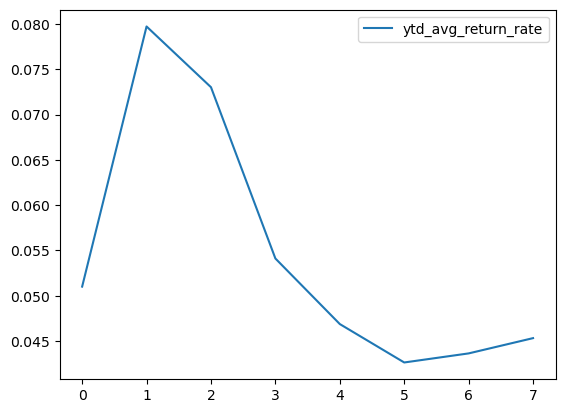

In [45]:
ytd_avg_lift = ytd_avg.groupby('report_month').apply(lambda x: x[x['cohort'] == 'Targeted']['ytd_avg_return_rate'].reset_index() - x[x['cohort'] == 'Holdout']['ytd_avg_return_rate'].reset_index()).reset_index().drop(['level_1', 'index'], axis=1)
ytd_avg_lift.plot()

In [50]:
%%bigquery ytd_inc

WITH a AS
(
	SELECT  report_month
	       ,COUNT(distinct CASE WHEN cohort = 'Targeted' THEN aid END )            AS Distinct_Cohort_Size_Targeted
            ,COUNT(distinct CASE WHEN cohort = 'Holdout' THEN aid END)              AS Distinct_Cohort_Size_Holdout
           ,SUM(CASE WHEN cohort = 'Targeted' THEN viewer END )                    AS Total_Returns_Targeted
           ,SUM(CASE WHEN cohort = 'Holdout' THEN viewer END)                      AS Total_Returns_Holdout
	FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.SILVER_EMAIL_CHANNEL_PERFORMANCE_MONTHLY`
	WHERE report_month >= '2023-01-01'
	GROUP BY  1
	ORDER BY 1
), b AS (
    SELECT  report_month
        ,Distinct_Cohort_Size_Targeted
        ,Distinct_Cohort_Size_Holdout
        ,(safe_divide(Total_Returns_Targeted,Distinct_Cohort_Size_Targeted) - safe_divide(Total_Returns_Holdout,Distinct_Cohort_Size_Holdout)) * Distinct_Cohort_Size_Targeted                                         AS Returns_Incrementals
    FROM a
), c AS (
    SELECT  report_month
        ,Distinct_Cohort_Size_Targeted
        ,Distinct_Cohort_Size_Holdout
        ,Returns_Incrementals
        ,SUM(Returns_Incrementals) OVER(ORDER BY report_month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS ytd_sum_incrementals
        ,SUM(Distinct_Cohort_Size_Targeted) OVER(ORDER BY report_month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)                AS ytd_avg_users
    FROM b
    GROUP BY  1,2,3,4
    ORDER BY 1,2 DESC
)
SELECT report_month, Distinct_Cohort_Size_Targeted, Returns_Incrementals, ytd_sum_incrementals, ytd_sum_incrementals/ytd_avg_users as cumulative_avg_return_rate
FROM c

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: >

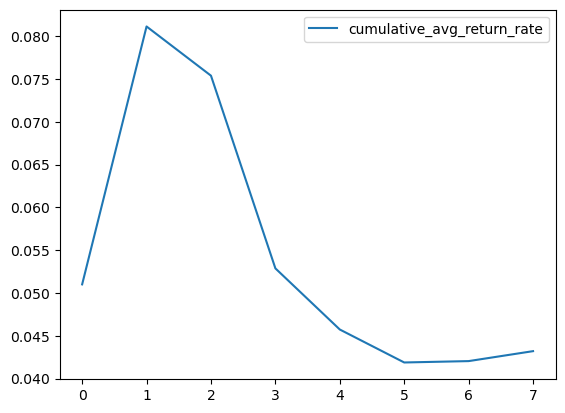

In [52]:
ytd_inc[['report_month', 'cumulative_avg_return_rate']].plot()

In [53]:
ytd_inc.to_excel('ytd_cumulative.xlsx')

# Transactional email openers

In [68]:
%%bigquery

select * from `nbcu-ds-sandbox-a-001.sl_sandbox.price_increase_email_table_cohort` limit 10;

Query is running:   0%|          |

Downloading:   0%|          |

,adobe_tracking_id,delivered_flag,other_opened_flag,non_opened_flag
0,lbzk1lKx1Ki9p5rmvuAO7xSd69/wjn1veT769QNLf0I=,Yes,No,Yes
1,jVf7UMKI1Aorh1VEWDrmawSZX9jr22cdTQTHFuRQtT0=,Yes,No,Yes
2,DTCpy6KJwzoICJCDDxWQwKRIWyceCRDGAXg8YX9ofjU=,Yes,No,Yes
3,nfdErhUsWVfyZTE/5SFPpZBhKkZFqYZfJYJtfjBXzMk=,Yes,No,Yes
4,Z/QrVmLgWu0cV7iVV9rPGVM0evxlT5Tl2mHwdavgue0=,Yes,No,Yes
5,3fPvsbLwHdMUfHRgGw9pyO2lHVpAD4D/8HJOJo8yi2M=,Yes,No,Yes
6,Esf3ycO+tjnbCYNE3FaFWIGRP/HPHi3crZHPLctOEJE=,Yes,No,Yes
7,+eGq1vhRPkOtGOMG4i/VcNsmLQ3+vISSMhVTYG1i82A=,Yes,No,Yes
8,MrVBGnmV/Q6XqLjfPB31lyB1SiPm8cCbMVdCafonoXI=,Yes,No,Yes
9,xNZoVKB6kWGIZSj8nEabGqXjS0lsOYFyJJ3+OaN510U=,Yes,No,Yes


In [ ]:
%%bigquery

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.Transcomm_Email_Openers` AS ( 
    SELECT  report_month
        ,a.aid
        ,a.cohort
        ,CASE WHEN b.adobe_tracking_id IS NOT NULL THEN 'Transactional Email User Opener'  ELSE 'User Did Not Open Transactional Email' END AS transactional_email_status
        ,EOM_Paid_Churn_Num
        ,EOM_Paid_Churn_Denom
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.SILVER_EMAIL_CHANNEL_PERFORMANCE_MONTHLY` a
    LEFT JOIN
    (
        SELECT  adobe_tracking_id
        FROM `nbcu-ds-sandbox-a-001.sl_sandbox.price_increase_email_table_cohort`
        WHERE delivered_flag = 'Yes'
        AND other_opened_flag = 'Yes' 
    ) b
    ON a.aid = b.adobe_tracking_id
)

In [71]:
%%bigquery

CREATE OR REPLACE TABLE `nbcu-ds-sandbox-a-001.SLi_sandbox.July_Transcomm_Email_Openers` AS ( 
    SELECT  a.aid
        ,a.cohort
        ,CASE WHEN b.adobe_tracking_id IS NOT NULL THEN 'Transactional Email User Opener'  ELSE 'User Did Not Open Transactional Email' END AS transactional_email_status
        ,EOM_Paid_Churn_Num
        ,EOM_Paid_Churn_Denom
    FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.Email_Channel_Base_Jul_2023` a
    LEFT JOIN
    (
        SELECT  adobe_tracking_id
        FROM `nbcu-ds-sandbox-a-001.sl_sandbox.price_increase_email_table_cohort`
        WHERE delivered_flag = 'Yes'
        AND other_opened_flag = 'Yes' 
    ) b
    ON a.aid = b.adobe_tracking_id
)

Query is running:   0%|          |

""


In [75]:
%%bigquery

select cohort, transactional_email_status, SUM(EOM_Paid_Churn_Denom) as paid_subs, SUM(EOM_Paid_Churn_Num) / SUM(EOM_Paid_Churn_Denom) as churn_rate
FROM `nbcu-ds-sandbox-a-001.SLi_sandbox.July_Transcomm_Email_Openers`
group by 1,2
order by 1 desc, 2

Query is running:   0%|          |

Downloading:   0%|          |

,cohort,transactional_email_status,paid_subs,churn_rate
0,Targeted,Transactional Email User Opener,2848955,0.046033
1,Targeted,User Did Not Open Transactional Email,10945528,0.046034
2,Holdout,Transactional Email User Opener,97214,0.045940
3,Holdout,User Did Not Open Transactional Email,492756,0.045483


# Pull data from prod

In [15]:
%%bigquery df

WITH a AS
(
	SELECT  report_month
	       ,SUM(CASE WHEN cohort = 'Targeted' THEN users END)                                    AS Email_Targetable
	       ,SUM(CASE WHEN cohort = 'Holdout' THEN users END)                                     AS Email_Holdout
           ,SUM(CASE WHEN cohort = 'Targeted' THEN Free_to_Paid_Denom END)                       AS FTP_eligible
	       ,SUM(CASE WHEN cohort = 'Targeted' THEN Free_to_Paid_Num END)/SUM(CASE WHEN cohort = 'Targeted' THEN Free_to_Paid_Denom END) AS Email_Targetable_FTP
	       ,SUM(CASE WHEN cohort = 'Holdout' THEN Free_to_Paid_Num END)/SUM(CASE WHEN cohort = 'Holdout' THEN Free_to_Paid_Denom END)  AS Email_Holdout_FTP
	FROM `nbcu-ds-prod-001.PeacockDataMartMarketingGold.GOLD_EMAIL_CHANNEL_PERFORMANCE`
    WHERE result_type = 'Monthly'
    and report_month >= '2023-01-01'
    GROUP BY 1
)
SELECT  *
       ,Email_Targetable_FTP - Email_Holdout_FTP                      AS lift
       ,Email_Targetable_FTP/Email_Holdout_FTP*100                    AS index
       ,FTP_eligible * (Email_Targetable_FTP - Email_Holdout_FTP) AS incrementals
FROM a
order by 1

Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
df.to_excel('monthly_results_ytd.xlsx')

# Active Days

In [5]:
%%bigquery

select SUM(active_days)/COUNT(DISTINCT adobe_tracking_id)
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
LEFT JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Video_Viewing_Oct_2023` using(adobe_tracking_id)
WHERE paying_account_flag = 'Paying' and report_date = '2023-10-31'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,7.162257


In [4]:
%%bigquery

select SUM(active_days)/COUNT(DISTINCT adobe_tracking_id)
FROM `nbcu-ds-prod-001.PeacockDataMartSilver.SILVER_USER`
JOIN `nbcu-ds-sandbox-a-001.SLi_sandbox.Video_Viewing_Oct_2023` using(adobe_tracking_id)
WHERE paying_account_flag = 'Paying' and report_date = '2023-10-31'

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,9.494279
